# Image classification project for the course Introduction to Deep Learning

## Imports and loading data

In [1]:
# Importing needed libraries here

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import keras
from keras import layers, models, optimizers, regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from keras.datasets import cifar100
from keras.models import Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# CIFAR-100 class names
# Source: https://www.geeksforgeeks.org/cifar-100-dataset/
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [3]:
# Load CIFAR-100 dataset
(cifar100_train, cifar100_test) = tf.keras.datasets.cifar100.load_data()

(x_train, y_train) = cifar100_train
(x_test, y_test) = cifar100_test

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


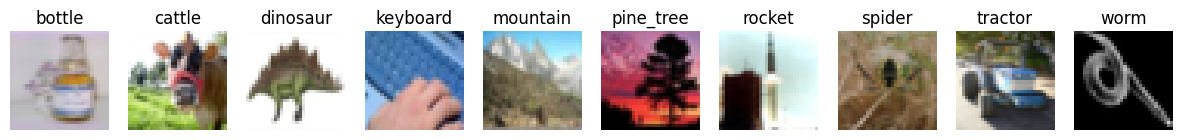

In [4]:
# Using 10 classes and 200 images per class
classes = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
num_images = 200

# Names of the selected classes
selected_class_names = [class_names[i] for i in classes]

# Create the test and training sets
x_train_selected, y_train_selected = [], []
x_test_selected, y_test_selected = [], []

for class_id in classes:
    train_indices = np.where(y_train.flatten() == class_id)[0][:num_images]
    test_indices = np.where(y_test.flatten() == class_id)[0][:num_images // 5]

    x_train_selected.append(x_train[train_indices])
    y_train_selected.append(y_train[train_indices])
    x_test_selected.append(x_test[test_indices])
    y_test_selected.append(y_test[test_indices])

# Convert lists to NumPy arrays
x_train_selected = np.concatenate(x_train_selected, axis=0)
y_train_selected = np.concatenate(y_train_selected, axis=0)
x_test_selected = np.concatenate(x_test_selected, axis=0)
y_test_selected = np.concatenate(y_test_selected, axis=0)

# Create a mapping from original class labels to new labels (0 to 9)
class_mapping = {class_id: i for i, class_id in enumerate(classes)}

# Map original class labels to new labels
y_train_selected = np.vectorize(class_mapping.get)(y_train_selected)
y_test_selected = np.vectorize(class_mapping.get)(y_test_selected)

# One-hot encode the labels
y_train_selected = tf.keras.utils.to_categorical(y_train_selected, len(classes))
y_test_selected = tf.keras.utils.to_categorical(y_test_selected, len(classes))

# Normalize the image data
x_train_selected = x_train_selected.astype("float32") / 255
x_test_selected = x_test_selected.astype("float32") / 255

# Display one image from each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))

for i, class_id in enumerate(classes):
    index = np.where(y_train.flatten() == class_id)[0][0]  # Select first occurrence
    image = x_train[index]

    axes[i].imshow(image)
    axes[i].set_title(class_names[class_id])
    axes[i].axis("off")

plt.show()


In [5]:
print(selected_class_names)

['bottle', 'cattle', 'dinosaur', 'keyboard', 'mountain', 'pine_tree', 'rocket', 'spider', 'tractor', 'worm']


## Function for the CNN

In [6]:
# Function for building the CNN (with preset hyper parameters)

def cnn(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        optimizer_name='adam',
        learning_rate=0.001,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    # When calling with conv_layers=3, it has three stacks so total of 6 convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.2))
        filters *= 2

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping (starting from 5th epoch for warm-up)
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

## Test with default parameters

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 325ms/step - accuracy: 0.2623 - loss: 2.2721 - val_accuracy: 0.1000 - val_loss: 2.6058
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.5166 - loss: 1.4378 - val_accuracy: 0.1000 - val_loss: 2.9711
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.5970 - loss: 1.2159 - val_accuracy: 0.1225 - val_loss: 3.5428
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.6571 - loss: 1.0094 - val_accuracy: 0.2100 - val_loss: 2.9494
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 336ms/step - accuracy: 0.7289 - loss: 0.8341 - val_accuracy: 0.1900 - val_loss: 3.0328
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 303ms/step - accuracy: 0.7634 - loss: 0.7023 - val_accuracy: 0.2800 - val_loss: 2.6087
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.8034 - loss: 0.5985 - val_accuracy: 0.4500 - val_loss: 1.7234
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - accuracy: 0.7974 - loss: 0.5690 - val_accu

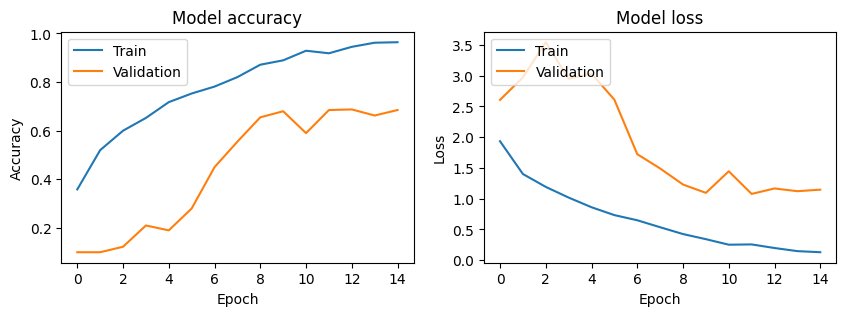

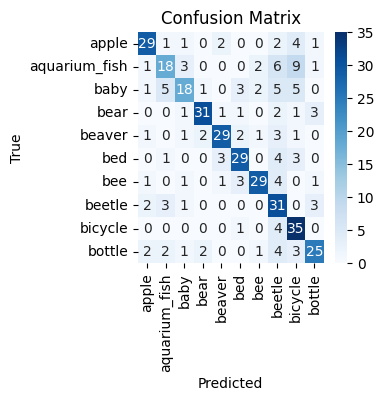

In [ ]:
# Test with default parameters to get a baseline score
model_default = cnn()

### Baseline scores
Total training time: 393.46 seconds
Test accuracy: 0.6850
Test loss: 1.0781


## Experiments

### Experiment 1 (dense layer depth)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.2801 - loss: 2.3577 - val_accuracy: 0.1000 - val_loss: 2.8640
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.5341 - loss: 1.4176 - val_accuracy: 0.1275 - val_loss: 3.6400
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.6284 - loss: 1.1316 - val_accuracy: 0.1100 - val_loss: 4.3878
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step - accuracy: 0.6645 - loss: 0.9695 - val_accuracy: 0.1000 - val_loss: 5.4638
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.7300 - loss: 0.7881 - val_accuracy: 0.1700 - val_loss: 5.0165
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.7868 - loss: 0.6589 - val_accuracy: 0.2475 - val_loss: 3.5725
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.8145 - loss: 0.5792 - val_accuracy: 0.4625 - val_loss: 1.8141
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.8350 - loss: 0.5146 - val_accu

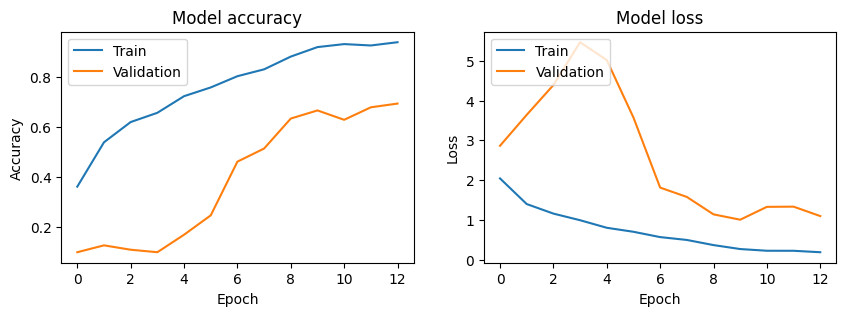

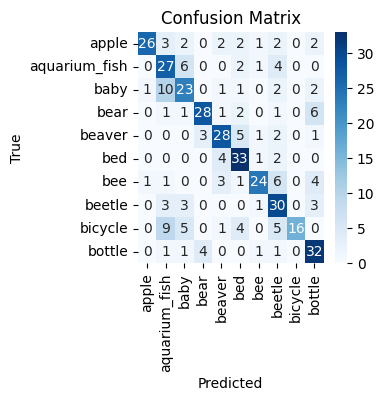

In [19]:
# Experiment 1: Increase dense layer depth
cnn(dense_units=256)


Experiment 1, increased dense layer depth to 256

Total training time: 263.75 seconds
Test accuracy: 0.6675
Test loss: 1.0077

Faster, worse accuracy, better loss

### Experiment 2 (convolutional layers)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1973 - loss: 2.4769 - val_accuracy: 0.1000 - val_loss: 2.5475
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.3747 - loss: 1.7856 - val_accuracy: 0.1000 - val_loss: 2.8991
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.4823 - loss: 1.5052 - val_accuracy: 0.1250 - val_loss: 3.5572
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5521 - loss: 1.3209 - val_accuracy: 0.1275 - val_loss: 3.3334
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5692 - loss: 1.2440 - val_accuracy: 0.2275 - val_loss: 2.9487
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6067 - loss: 1.1643 - val_accuracy: 0.2775 - val_loss: 2.4934
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6651 - loss: 0.9888 - val_accuracy: 0.4225 - val_loss: 1.7887
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7114 - loss: 0.8656 - val_accuracy: 0.5450 - va

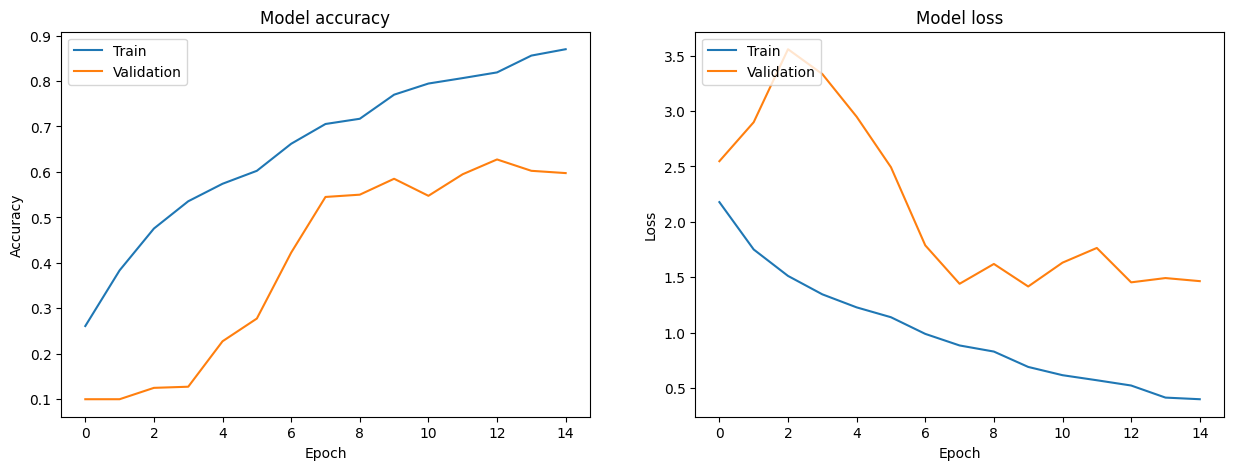

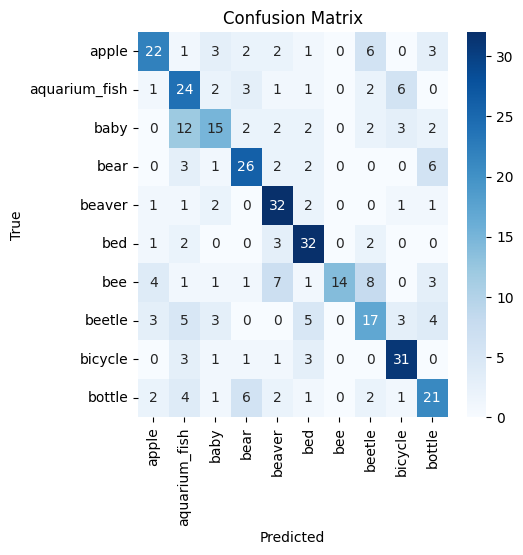

In [ ]:
# Experiment 2: More convolutional layers
cnn(conv_layers=5)

Experiment 2, increased convolutional layers to 5

Total training time: 1960.59 seconds
Test accuracy: 0.5850
Test loss: 1.4178

Significantly slower, worse accuracy, worse loss

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.3498 - loss: 2.0573 - val_accuracy: 0.1325 - val_loss: 2.4081
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6895 - loss: 1.0208 - val_accuracy: 0.1000 - val_loss: 3.4665
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.8062 - loss: 0.6414 - val_accuracy: 0.1000 - val_loss: 5.4417
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9070 - loss: 0.3782 - val_accuracy: 0.1000 - val_loss: 4.4370
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9731 - loss: 0.1894 - val_accuracy: 0.1000 - val_loss: 4.4005
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9799 - loss: 0.1227 - val_accuracy: 0.2000 - val_loss: 3.4627
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9913 - loss: 0.0747 - val_accuracy: 0.3200 - val_loss: 2.6809
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9945 - loss: 0.0491 - val_accuracy: 

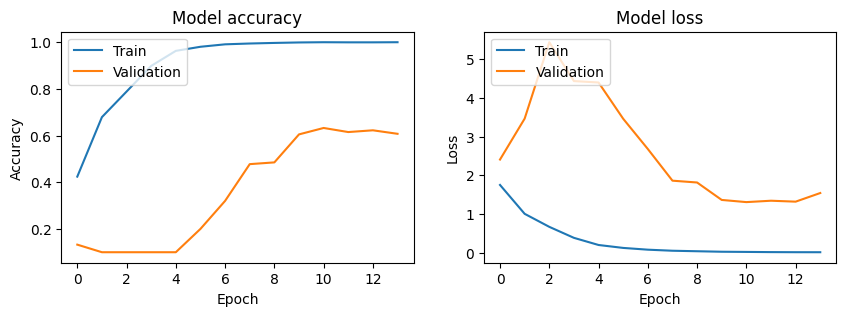

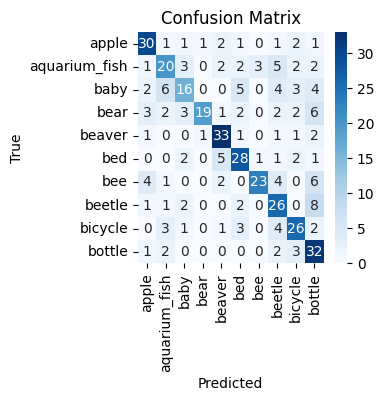

In [21]:
# Less convolutional layers
cnn(conv_layers=1)


1 convolutional layer

Total training time: 122.18 seconds
Test accuracy: 0.6325
Test loss: 1.3077

Fast, not as accurate, worse loss, clearly overfits

### Experiment 3 (activation functions)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.3014 - loss: 2.2796 - val_accuracy: 0.1000 - val_loss: 2.5265
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.4640 - loss: 1.4999 - val_accuracy: 0.1000 - val_loss: 2.4549
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.5043 - loss: 1.4666 - val_accuracy: 0.1000 - val_loss: 2.3964
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.5996 - loss: 1.1753 - val_accuracy: 0.1000 - val_loss: 3.3840
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - accuracy: 0.6278 - loss: 1.0716 - val_accuracy: 0.1150 - val_loss: 3.7948
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.7127 - loss: 0.8586 - val_accuracy: 0.1800 - val_loss: 3.2117
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.7402 - loss: 0.7588 - val_accuracy: 0.3375 - val_loss: 2.3655
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.7553 - loss: 0.6713 - val_accu

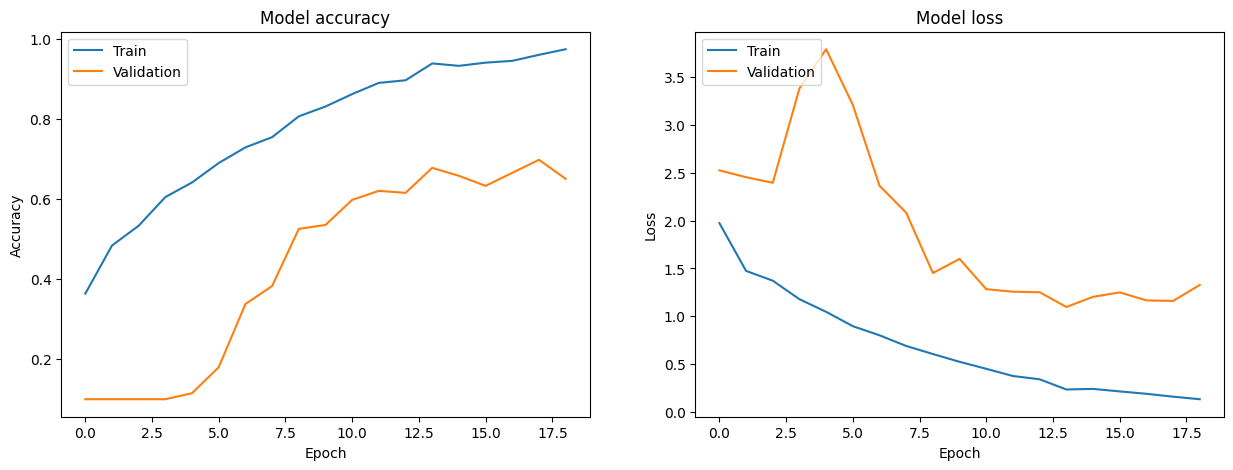

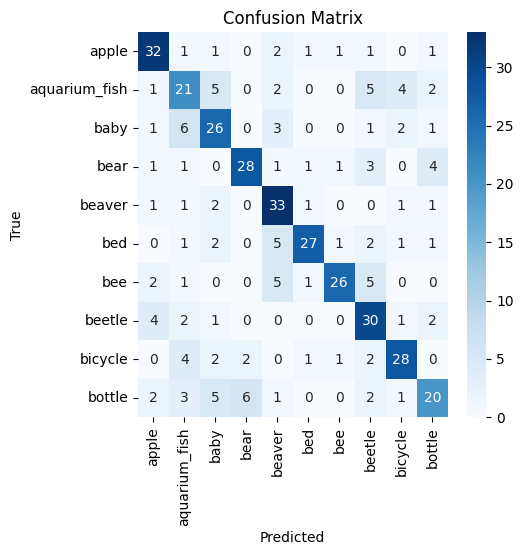

In [ ]:
# Experiment 3: Different activation functions
cnn(activation='sigmoid')


Experiment 3, Sigmoid activation function

Total training time: 410.90 seconds
Test accuracy: 0.6775
Test loss: 1.0958

Slower, worse accuracy, worse loss


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 314ms/step - accuracy: 0.2569 - loss: 2.3211 - val_accuracy: 0.1700 - val_loss: 2.3452
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.4089 - loss: 1.6978 - val_accuracy: 0.3225 - val_loss: 1.9821
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - accuracy: 0.4781 - loss: 1.5296 - val_accuracy: 0.3600 - val_loss: 2.0552
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.5259 - loss: 1.4009 - val_accuracy: 0.3575 - val_loss: 2.0569
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.5446 - loss: 1.3069 - val_accuracy: 0.3800 - val_loss: 1.9116
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.5787 - loss: 1.2148 - val_accuracy: 0.4400 - val_loss: 1.7704
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - accuracy: 0.5966 - loss: 1.1504 - val_accuracy: 0.4600 - val_loss: 1.6075
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.6682 - loss: 0.9808 - val_accu

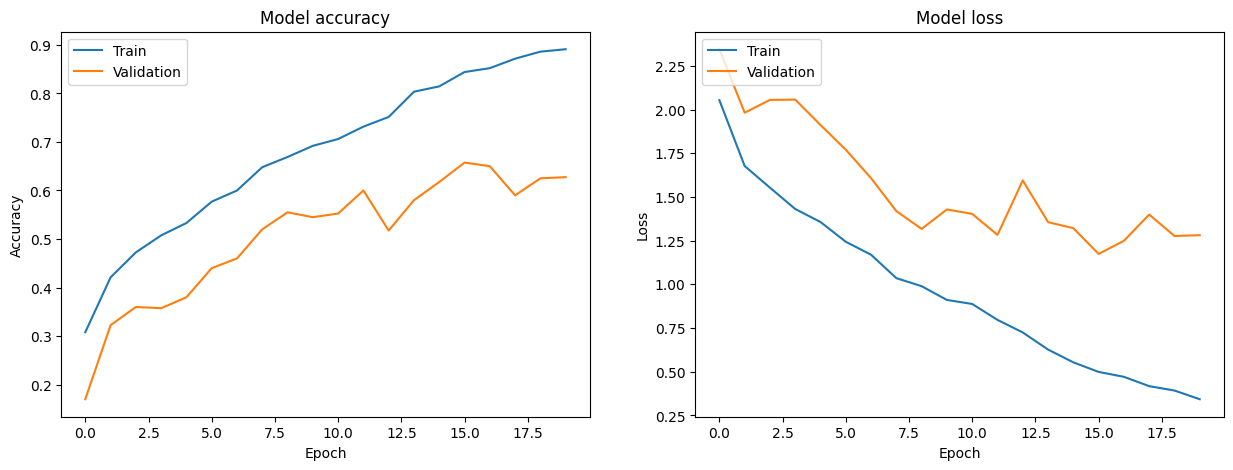

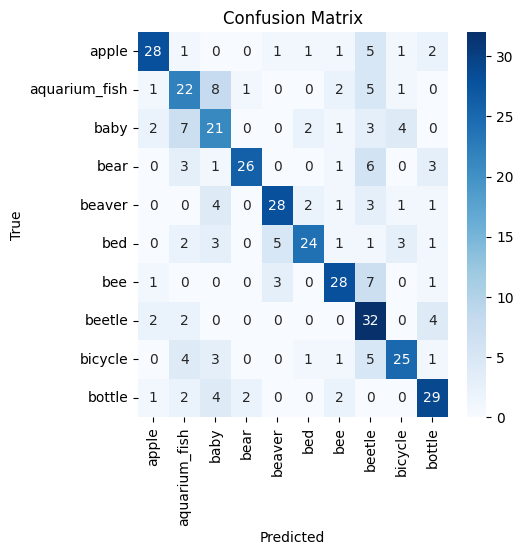

In [ ]:
cnn(activation='tanh')


Tanh activation function

Total training time: 474.09 seconds
Test accuracy: 0.6575
Test loss: 1.1742

Slower, worse accuracy, worse loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.3149 - loss: 2.2231 - val_accuracy: 0.1250 - val_loss: 2.4518
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.5345 - loss: 1.3637 - val_accuracy: 0.1625 - val_loss: 2.7445
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.5922 - loss: 1.2211 - val_accuracy: 0.1875 - val_loss: 3.0413
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.6788 - loss: 0.9777 - val_accuracy: 0.1175 - val_loss: 3.4963
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.7180 - loss: 0.8600 - val_accuracy: 0.3200 - val_loss: 2.4206
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.7805 - loss: 0.6751 - val_accuracy: 0.3625 - val_loss: 2.0631
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - accuracy: 0.7961 - loss: 0.5900 - val_accuracy: 0.4575 - val_loss: 1.6245
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.8389 - loss: 0.4781 - val_accu

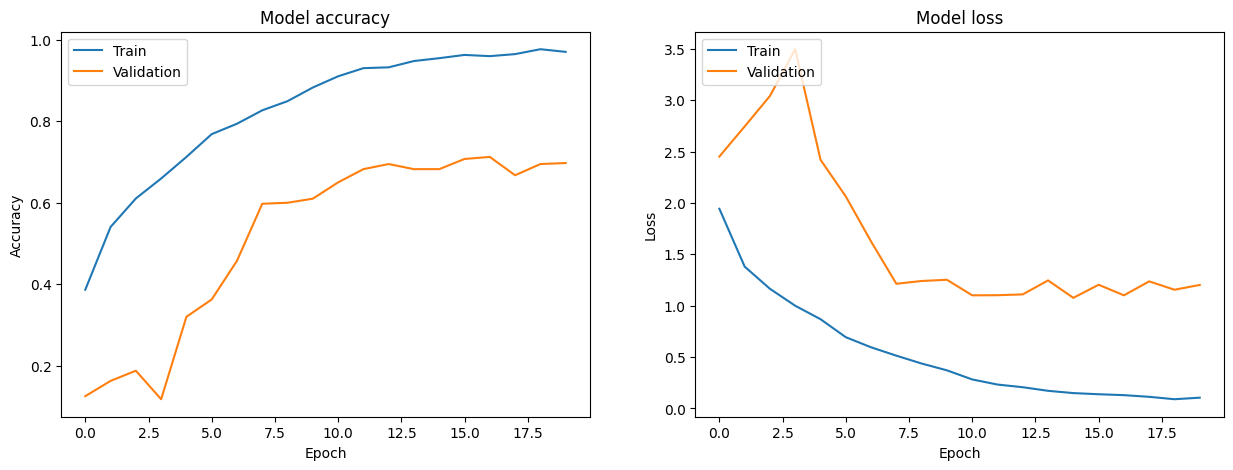

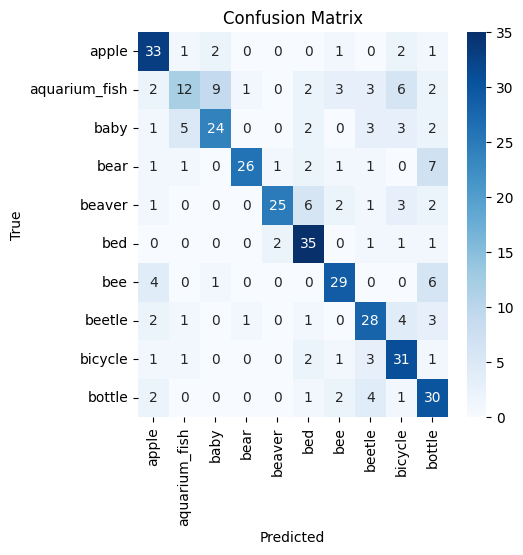

In [ ]:
cnn(activation='leaky_relu')


Leaky relu

Total training time: 433.51 seconds
Test accuracy: 0.6825
Test loss: 1.0764

Slower, otherwise pretty much the same as baseline

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.3234 - loss: 2.1798 - val_accuracy: 0.1325 - val_loss: 3.5957
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.5536 - loss: 1.3162 - val_accuracy: 0.2275 - val_loss: 3.2595
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.6432 - loss: 1.0822 - val_accuracy: 0.2325 - val_loss: 2.7375
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6768 - loss: 0.9511 - val_accuracy: 0.2500 - val_loss: 2.6483
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.7248 - loss: 0.7916 - val_accuracy: 0.4625 - val_loss: 1.7930
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.7884 - loss: 0.6632 - val_accuracy: 0.5325 - val_loss: 1.4779
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 325ms/step - accuracy: 0.8309 - loss: 0.5117 - val_accuracy: 0.5800 - val_loss: 1.3584
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.8741 - loss: 0.4094 - val_accu

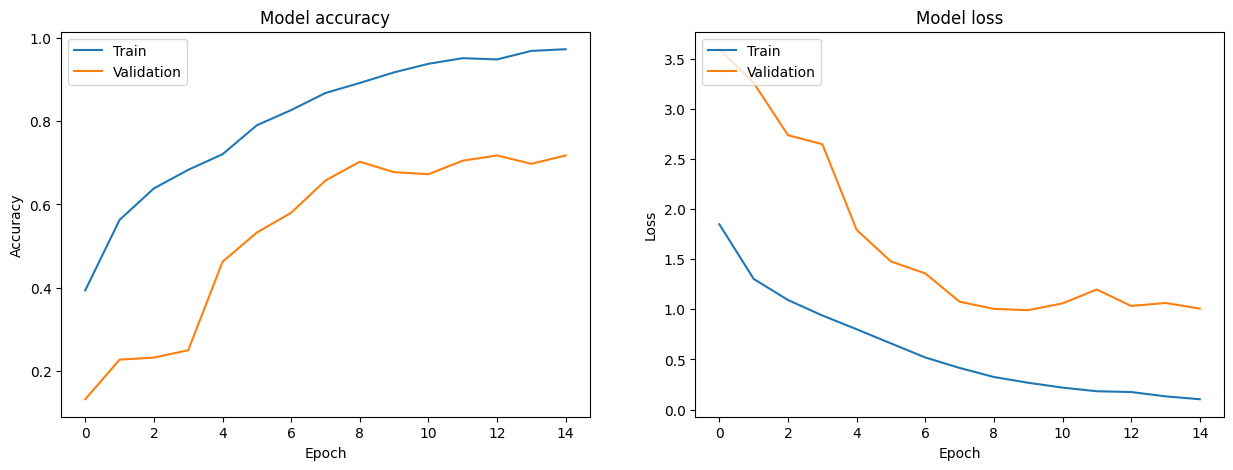

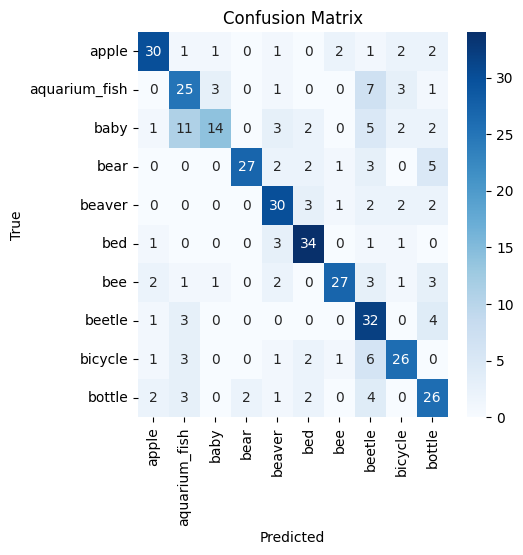

In [ ]:
cnn(activation='elu')


Elu

Total training time: 493.11 seconds
Test accuracy: 0.6775
Test loss: 0.9920

Slower, worse accuracy, better loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 391ms/step - accuracy: 0.2891 - loss: 2.2838 - val_accuracy: 0.1000 - val_loss: 2.4177
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.5406 - loss: 1.3187 - val_accuracy: 0.1000 - val_loss: 2.8565
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.6242 - loss: 1.1366 - val_accuracy: 0.1000 - val_loss: 3.1174
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.7022 - loss: 0.8804 - val_accuracy: 0.1575 - val_loss: 2.5813
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.7713 - loss: 0.7103 - val_accuracy: 0.1575 - val_loss: 3.9588
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.7998 - loss: 0.5980 - val_accuracy: 0.3675 - val_loss: 2.0660
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - accuracy: 0.8300 - loss: 0.4912 - val_accuracy: 0.3350 - val_loss: 2.2030
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 287ms/step - accuracy: 0.8877 - loss: 0.3586 - val_accu

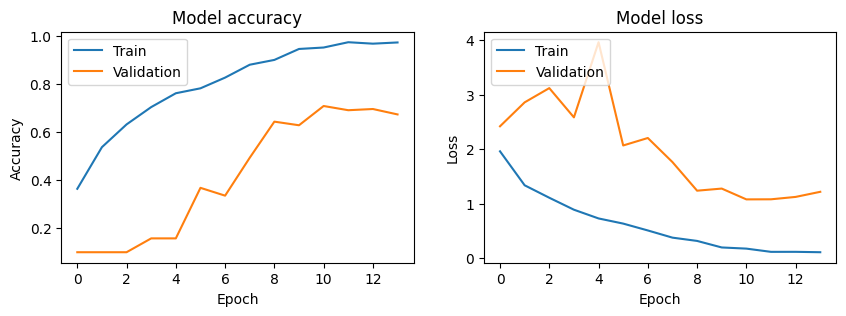

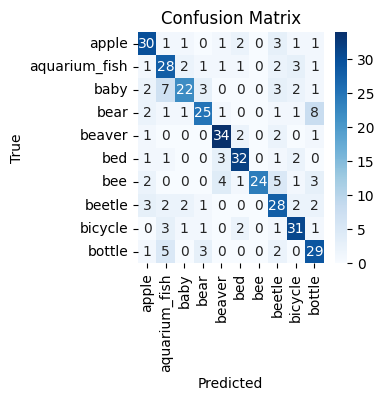

In [22]:
cnn(activation='swish')


Swish

Total training time: 291.47 seconds
Test accuracy: 0.7075
Test loss: 1.0776

Better accuracy, about the same loss, but signs of overfitting

### Experiment 4 (optimizers and learning rate)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - accuracy: 0.1021 - loss: 2.9325 - val_accuracy: 0.1000 - val_loss: 2.3500
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 316ms/step - accuracy: 0.2306 - loss: 2.4019 - val_accuracy: 0.0975 - val_loss: 2.3785
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.2865 - loss: 2.1126 - val_accuracy: 0.1025 - val_loss: 2.4422
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 336ms/step - accuracy: 0.3269 - loss: 2.0019 - val_accuracy: 0.1050 - val_loss: 2.5461
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.3466 - loss: 1.9743 - val_accuracy: 0.1525 - val_loss: 2.4305
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 324ms/step - accuracy: 0.3584 - loss: 1.8895 - val_accuracy: 0.1975 - val_loss: 2.2233
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.4194 - loss: 1.7634 - val_accuracy: 0.3350 - val_loss: 1.9141
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.4540 - loss: 1.6580 - val_accu

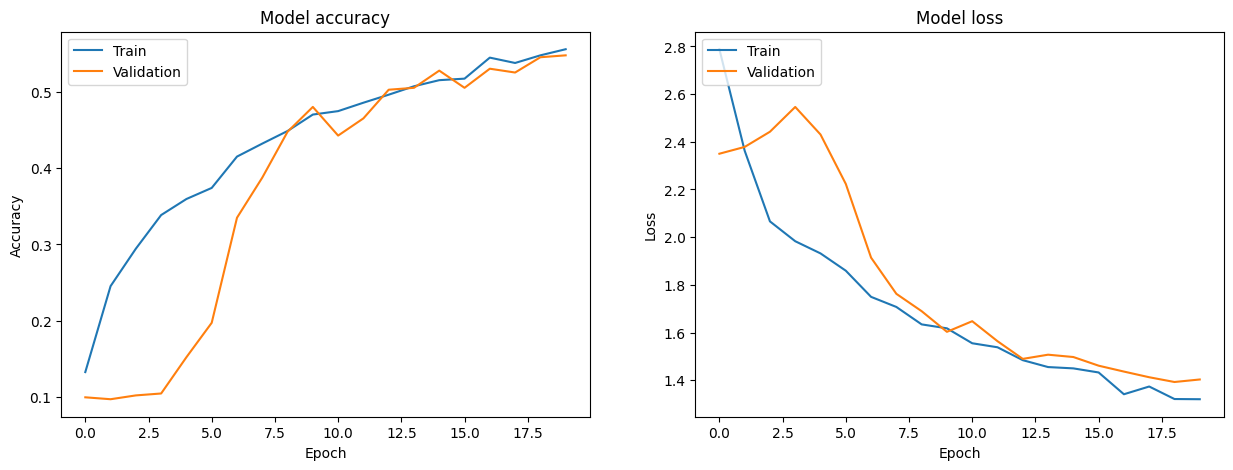

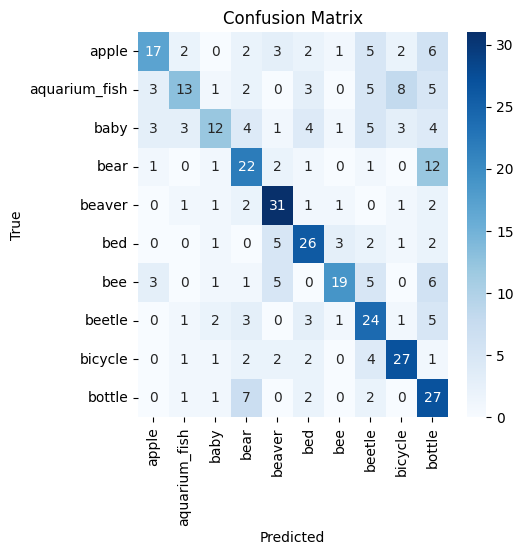

In [ ]:
# Experiment 4: Different optimizers and learning rates
model_4 = cnn(optimizer_name='sgd')


Total training time: 450.70 seconds
Test accuracy: 0.5450
Test loss: 1.3927

Worse accuracy and loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - accuracy: 0.2864 - loss: 2.2933 - val_accuracy: 0.1375 - val_loss: 2.4264
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - accuracy: 0.4685 - loss: 1.5975 - val_accuracy: 0.1075 - val_loss: 3.1493
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 0.5431 - loss: 1.3070 - val_accuracy: 0.1300 - val_loss: 5.7512
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.6385 - loss: 1.0609 - val_accuracy: 0.2525 - val_loss: 3.2864
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.7057 - loss: 0.8824 - val_accuracy: 0.3100 - val_loss: 2.5737
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.7739 - loss: 0.6769 - val_accuracy: 0.4850 - val_loss: 1.7309
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.8256 - loss: 0.5255 - val_accuracy: 0.4275 - val_loss: 1.8630
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.8547 - loss: 0.4571 - val_accu

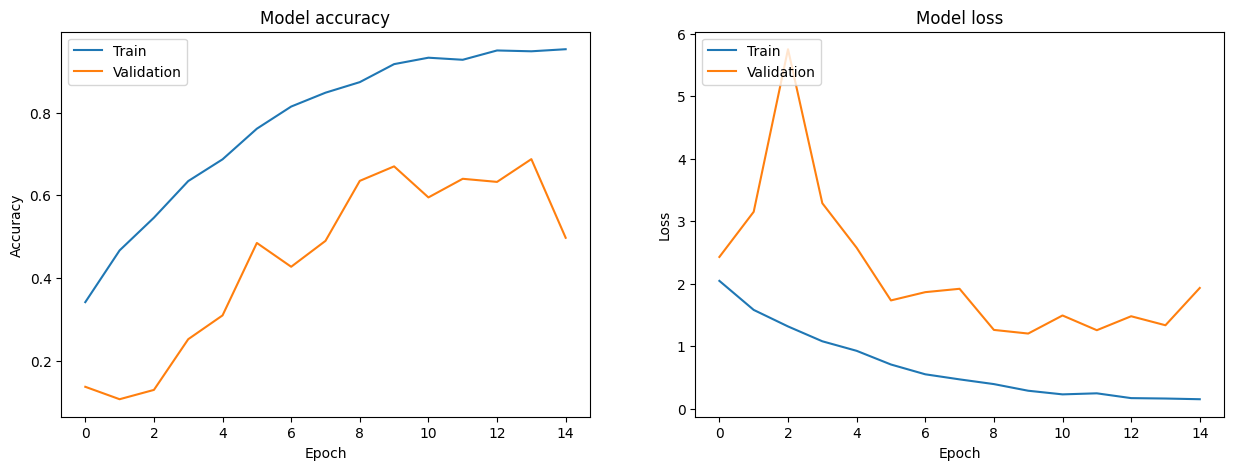

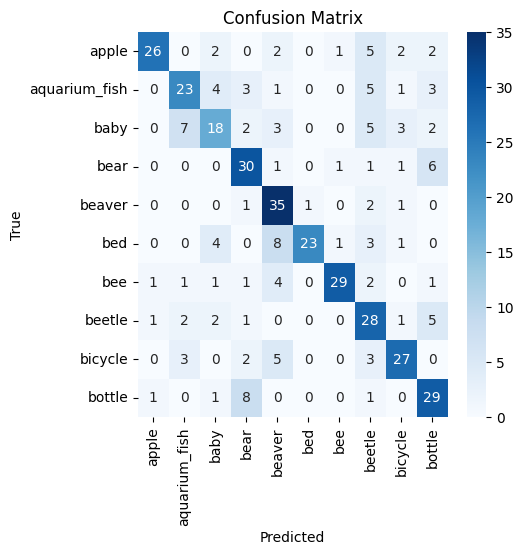

In [ ]:
model_4b = cnn(optimizer_name='rmsprop')


Total training time: 303.18 seconds
Test accuracy: 0.6700
Test loss: 1.2006

Worse accuracy, worse loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.2621 - loss: 2.3467 - val_accuracy: 0.1075 - val_loss: 14.8562
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.3788 - loss: 1.7734 - val_accuracy: 0.2950 - val_loss: 3.3319
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.4745 - loss: 1.5091 - val_accuracy: 0.1750 - val_loss: 3.9918
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.5428 - loss: 1.3738 - val_accuracy: 0.1775 - val_loss: 4.3823
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.6156 - loss: 1.1492 - val_accuracy: 0.3200 - val_loss: 2.4558
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 324ms/step - accuracy: 0.6143 - loss: 1.1266 - val_accuracy: 0.1975 - val_loss: 4.3734
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.6765 - loss: 0.9323 - val_accuracy: 0.4075 - val_loss: 2.0173
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - accuracy: 0.6761 - loss: 0.9117 - val_acc

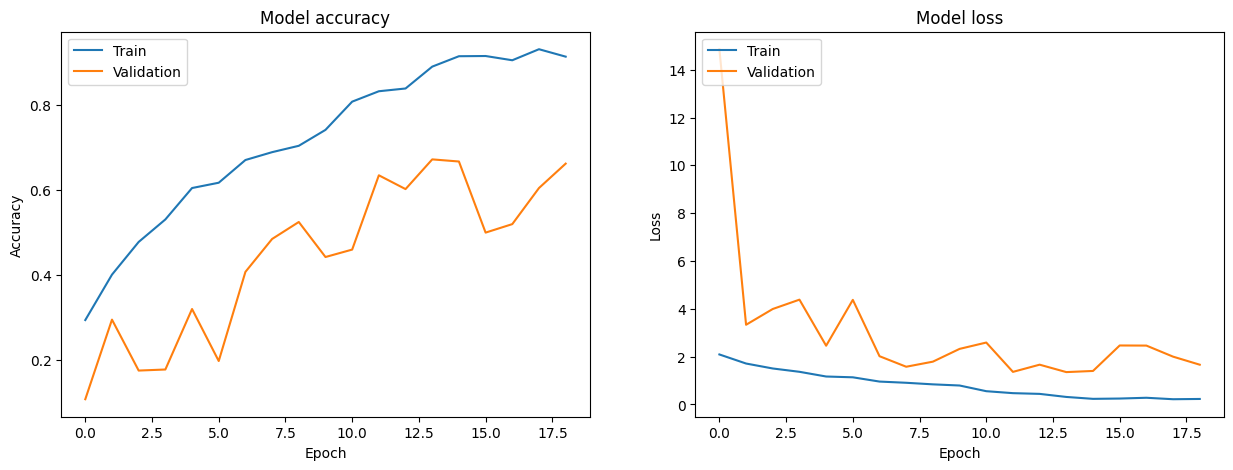

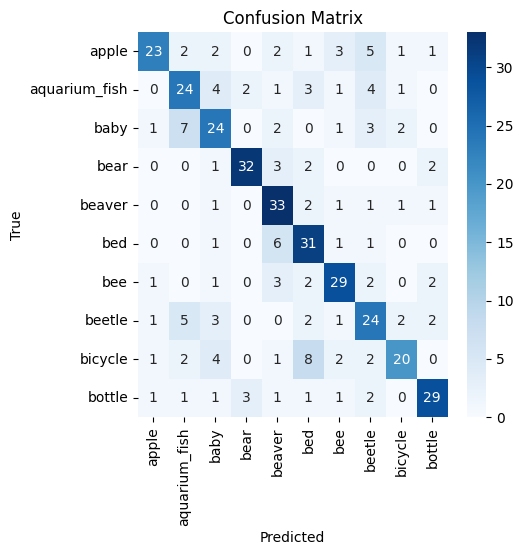

In [ ]:
model_4c = cnn(optimizer_name='adam', learning_rate=0.01)


Total training time: 455.27 seconds
Test accuracy: 0.6725
Test loss: 1.3522

Slower, about the same accuracy, worse loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.2119 - loss: 2.4571 - val_accuracy: 0.1150 - val_loss: 2.3721
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.3958 - loss: 1.8000 - val_accuracy: 0.1100 - val_loss: 2.5911
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.4808 - loss: 1.5190 - val_accuracy: 0.1400 - val_loss: 2.4616
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.5266 - loss: 1.3564 - val_accuracy: 0.1850 - val_loss: 2.4179
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.5682 - loss: 1.2723 - val_accuracy: 0.2525 - val_loss: 2.0402
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.6032 - loss: 1.1283 - val_accuracy: 0.4175 - val_loss: 1.6857
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - accuracy: 0.6481 - loss: 1.0271 - val_accuracy: 0.4725 - val_loss: 1.5131
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - accuracy: 0.6810 - loss: 0.9333 - val_accu

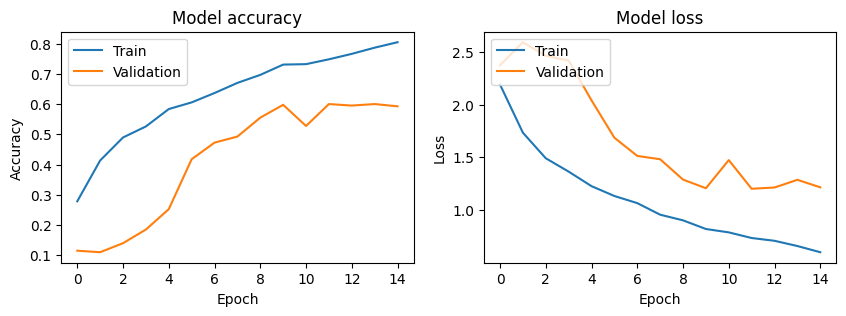

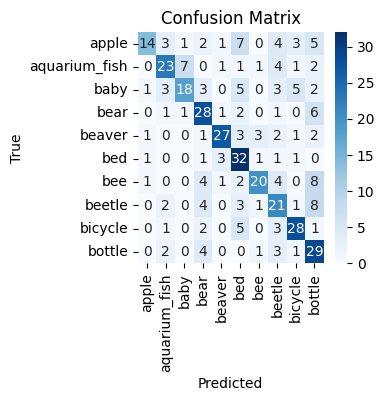

In [23]:
model_4d = cnn(optimizer_name='sgd', learning_rate=0.01)


Total training time: 298.17 seconds
Test accuracy: 0.6000
Test loss: 1.2019

Worse accuracy, worse loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 291ms/step - accuracy: 0.2077 - loss: 2.6979 - val_accuracy: 0.1000 - val_loss: 345.7508
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - accuracy: 0.3124 - loss: 1.9915 - val_accuracy: 0.2550 - val_loss: 8.5585
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.4335 - loss: 1.6362 - val_accuracy: 0.2625 - val_loss: 6.7809
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.5434 - loss: 1.3453 - val_accuracy: 0.3675 - val_loss: 2.7077
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - accuracy: 0.5638 - loss: 1.2135 - val_accuracy: 0.4625 - val_loss: 2.1475
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.6255 - loss: 1.0624 - val_accuracy: 0.4625 - val_loss: 2.1741
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.6869 - loss: 0.9080 - val_accuracy: 0.3825 - val_loss: 3.2052
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - accuracy: 0.7297 - loss: 0.7862 - val_ac

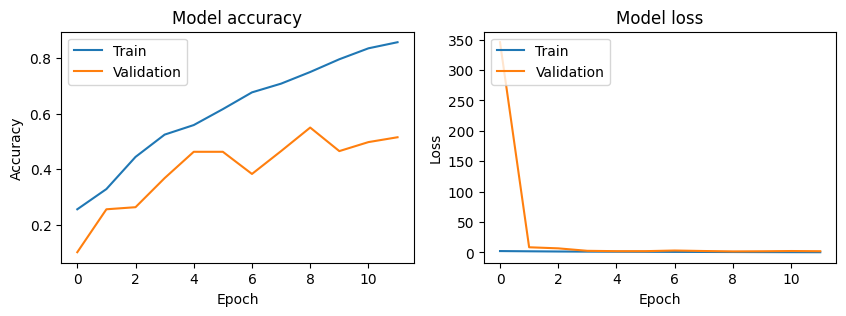

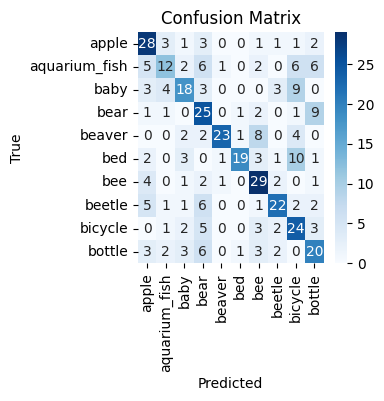

In [24]:
model_4e = cnn(optimizer_name='rmsprop', learning_rate=0.01)


Total training time: 270.07 seconds
Test accuracy: 0.5500
Test loss: 1.7608

Worse accuracy and loss

### Experiment 5 (batch size)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 600ms/step - accuracy: 0.2536 - loss: 2.3263 - val_accuracy: 0.1075 - val_loss: 2.4512
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 635ms/step - accuracy: 0.4863 - loss: 1.5271 - val_accuracy: 0.1000 - val_loss: 2.6126
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 554ms/step - accuracy: 0.5971 - loss: 1.1969 - val_accuracy: 0.1150 - val_loss: 2.8938
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - accuracy: 0.6607 - loss: 1.0099 - val_accuracy: 0.1050 - val_loss: 3.0973
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - accuracy: 0.7030 - loss: 0.8300 - val_accuracy: 0.1275 - val_loss: 3.2408
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 666ms/step - accuracy: 0.7556 - loss: 0.7153 - val_accuracy: 0.1450 - val_loss: 3.2739
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.7953 - loss: 0.6118 - val_accuracy: 0.1250 - val_loss: 3.2927
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 554ms/step - accuracy: 0.8227 - loss: 0.5539 - val_accu

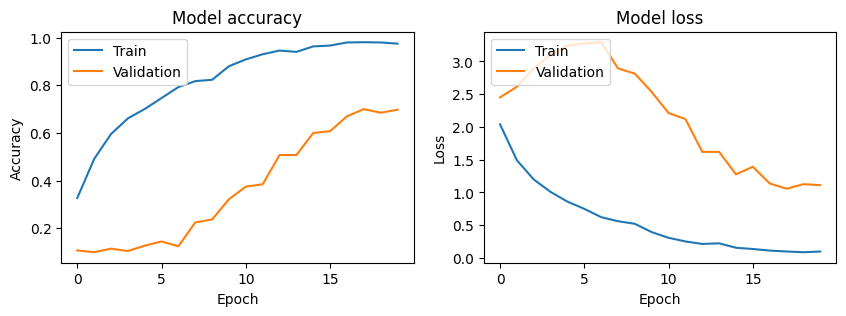

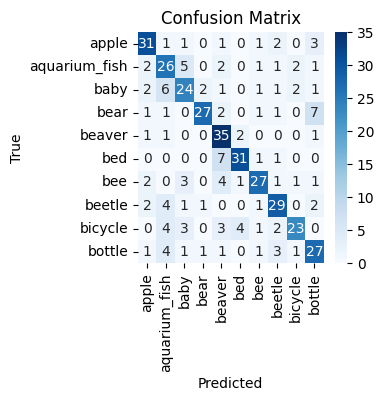

In [25]:
# Experiment 5: Batch size
model_5 = cnn(batch_size=64)

Total training time: 422.66 seconds
Test accuracy: 0.7000
Test loss: 1.0577

Better accuracy and loss but a little slower. Also clear signs of overfitting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 0.2690 - loss: 2.2683 - val_accuracy: 0.1125 - val_loss: 3.0209
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.4779 - loss: 1.5669 - val_accuracy: 0.1600 - val_loss: 3.6287
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.5647 - loss: 1.2828 - val_accuracy: 0.3000 - val_loss: 2.3044
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.6444 - loss: 1.0682 - val_accuracy: 0.5225 - val_loss: 1.4724
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.6549 - loss: 0.9775 - val_accuracy: 0.5075 - val_loss: 1.6007
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.6776 - loss: 0.9543 - val_accuracy: 0.5500 - val_loss: 1.4665
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.7375 - loss: 0.7474 - val_accuracy: 0.6325 - val_loss: 1.2409
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8029 - loss: 0

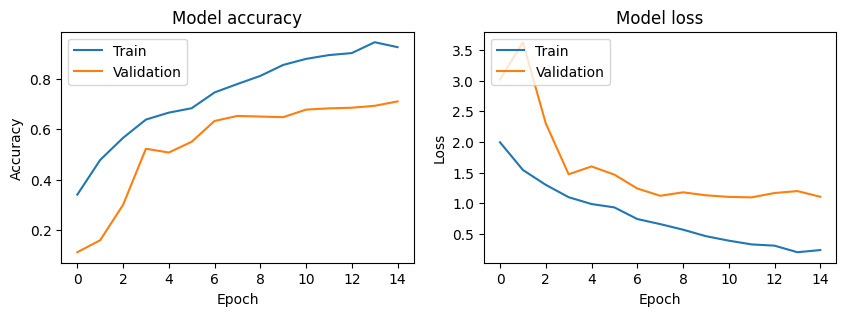

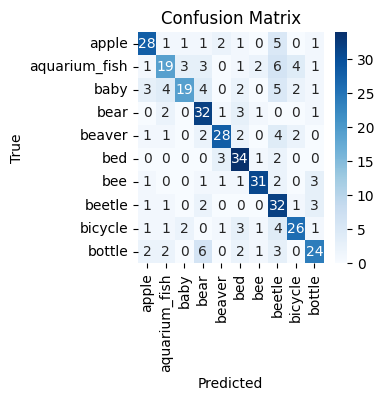

In [27]:
cnn(batch_size=16)

Total training time: 304.09 seconds
Test accuracy: 0.6825
Test loss: 1.0956

Little bit worse than baseline

### Experiment 6

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 630ms/step - accuracy: 0.3032 - loss: 2.2473 - val_accuracy: 0.1000 - val_loss: 2.4021
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 538ms/step - accuracy: 0.5471 - loss: 1.2947 - val_accuracy: 0.1000 - val_loss: 2.7124
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 552ms/step - accuracy: 0.6601 - loss: 1.0135 - val_accuracy: 0.1000 - val_loss: 3.2019
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step - accuracy: 0.6757 - loss: 0.9120 - val_accuracy: 0.1000 - val_loss: 2.9348
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 583ms/step - accuracy: 0.7350 - loss: 0.7775 - val_accuracy: 0.1000 - val_loss: 3.4901
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 521ms/step - accuracy: 0.8048 - loss: 0.6212 - val_accuracy: 0.1000 - val_loss: 3.9370
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 536ms/step - accuracy: 0.8342 - loss: 0.5073 - val_accuracy: 0.1000 - val_loss: 4.3095
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.8714 - loss: 0.4051 - val_accu

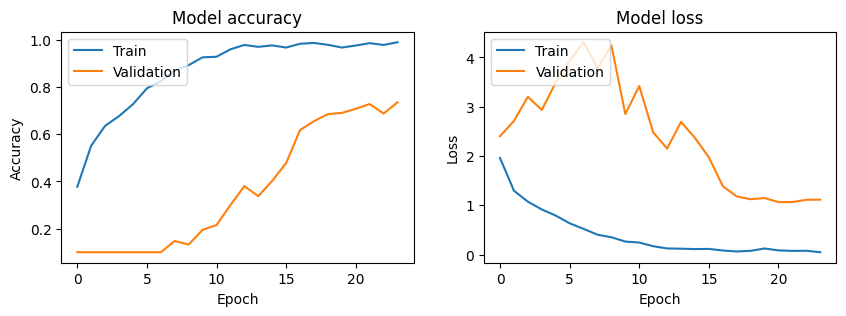

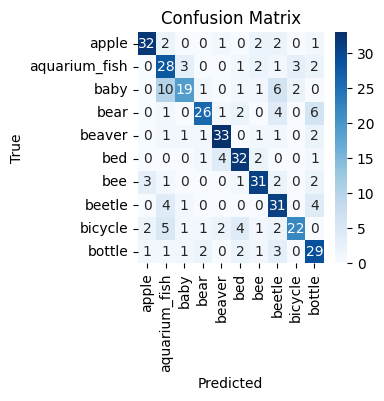

In [30]:
# Combining Swish and 64 batch size
cnn(activation='swish', batch_size=64, epochs=25)

Total training time: 480.65 seconds
Test accuracy: 0.7075
Test loss: 1.0648

Better accuracy, better loss, but not a huge improvement

# Making small changes to the function

In [7]:
# Here I removed one convolutional layer from the stack

def cnn2(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        #model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        #model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate)

    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

## Testing new model configuration

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2946 - loss: 2.2170 - val_accuracy: 0.1375 - val_loss: 3.1070
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.5148 - loss: 1.3875 - val_accuracy: 0.1000 - val_loss: 4.1178
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.6069 - loss: 1.1637 - val_accuracy: 0.1075 - val_loss: 3.5317
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.6292 - loss: 1.0396 - val_accuracy: 0.1500 - val_loss: 3.2527
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.6904 - loss: 0.9212 - val_accuracy: 0.1575 - val_loss: 3.3611
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.7469 - loss: 0.7804 - val_accuracy: 0.2475 - val_loss: 2.3492
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.7840 - loss: 0.6659 - val_accuracy: 0.3125 - val_loss: 2.2269
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.7913 - loss: 0.6038 - val_accura

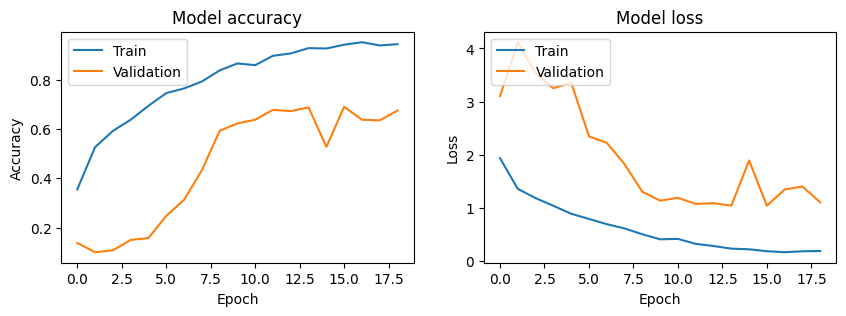

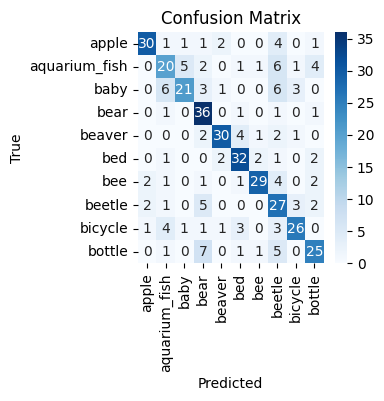

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.3047 - loss: 2.2037 - val_accuracy: 0.1000 - val_loss: 2.7895
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.5363 - loss: 1.3647 - val_accuracy: 0.1000 - val_loss: 3.7139
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.6137 - loss: 1.1484 - val_accuracy: 0.1150 - val_loss: 3.6522
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.6592 - loss: 1.0091 - val_accuracy: 0.1450 - val_loss: 3.4452
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.6878 - loss: 0.9241 - val_accuracy: 0.2225 - val_loss: 2.6640
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.7364 - loss: 0.7552 - val_accuracy: 0.4100 - val_loss: 1.9636
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.7889 - loss: 0.6611 - val_accuracy: 0.4150 - val_loss: 2.0959
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.8265 - loss: 0.5553 - val_accur

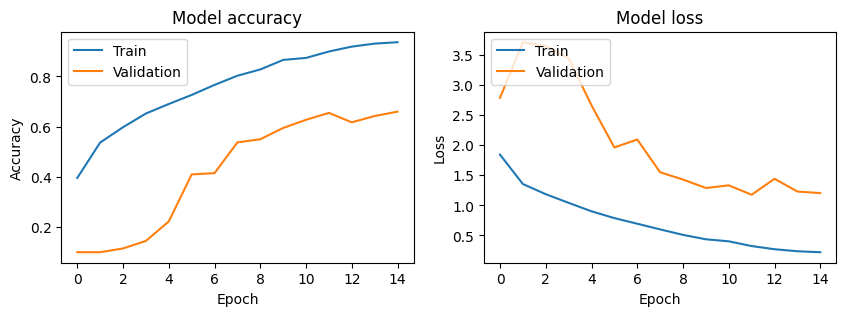

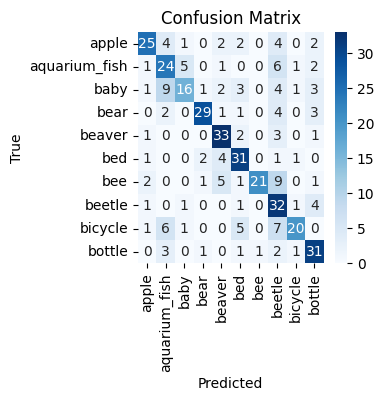

In [ ]:
model_b2 = cnn2()
model_c2 = cnn2(activation='elu')


Total training time: 202.72 seconds
Test accuracy: 0.6900
Test loss: 1.0454

Better accuracy and loss, faster

Total training time: 170.99 seconds
Test accuracy: 0.6550
Test loss: 1.1772

Elu wasn't any better.

Model works pretty well with reduced layers also. I will stick with this one but try it with higher dropout to see if it doesn't overfit so badly. Also increasing epochs.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.2505 - loss: 2.3280 - val_accuracy: 0.1000 - val_loss: 2.7023
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.4899 - loss: 1.5255 - val_accuracy: 0.1125 - val_loss: 3.2165
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5462 - loss: 1.3433 - val_accuracy: 0.1425 - val_loss: 2.9269
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.5951 - loss: 1.1766 - val_accuracy: 0.1775 - val_loss: 3.0533
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6572 - loss: 1.0628 - val_accuracy: 0.2300 - val_loss: 2.6210
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.6807 - loss: 0.9793 - val_accuracy: 0.3200 - val_loss: 2.0908
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.7211 - loss: 0.8362 - val_accuracy: 0.3875 - val_loss: 1.7922
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.7085 - loss: 0.8163 - val_accuracy: 

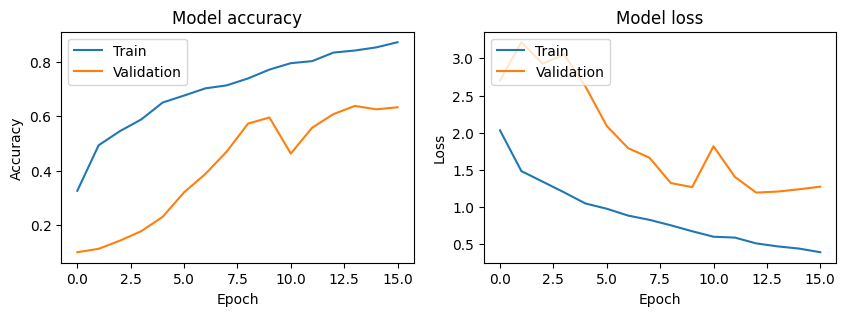

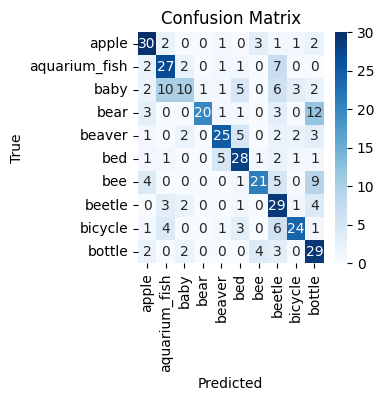

In [ ]:
cnn2(dropout=0.3, epochs=25)

Total training time: 159.58 seconds
Test accuracy: 0.6075
Test loss: 1.1947

Didn't work as I hoped.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.1410 - loss: 2.7670 - val_accuracy: 0.1000 - val_loss: 2.3907
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.2515 - loss: 2.1628 - val_accuracy: 0.1000 - val_loss: 2.4120
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.3436 - loss: 1.9361 - val_accuracy: 0.1000 - val_loss: 2.4751
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.3723 - loss: 1.8070 - val_accuracy: 0.1025 - val_loss: 2.4466
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.4222 - loss: 1.7489 - val_accuracy: 0.1575 - val_loss: 2.3186
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.4311 - loss: 1.6701 - val_accuracy: 0.2200 - val_loss: 2.2338
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.4314 - loss: 1.6845 - val_accuracy: 0.2675 - val_loss: 2.1428
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4798 - loss: 1.5217 - val_accuracy:

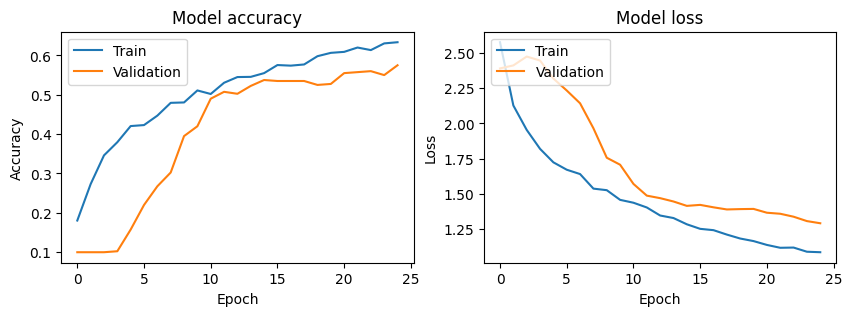

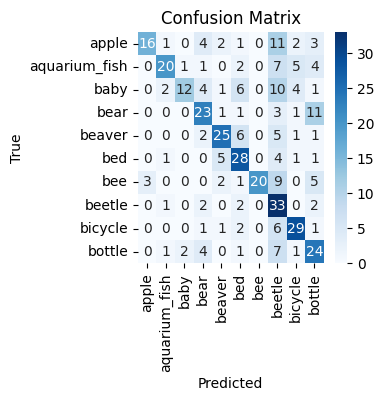

In [ ]:
cnn2(dropout=0.3, epochs=25, learning_rate=0.0001)

Total training time: 237.50 seconds
Test accuracy: 0.5750
Test loss: 1.2904

Smaller learning rate didn't help

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.3308 - loss: 2.0812 - val_accuracy: 0.1000 - val_loss: 2.5592
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.6634 - loss: 1.0334 - val_accuracy: 0.1025 - val_loss: 3.2023
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7370 - loss: 0.7666 - val_accuracy: 0.1300 - val_loss: 3.5168
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.8589 - loss: 0.4769 - val_accuracy: 0.1325 - val_loss: 3.3698
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9127 - loss: 0.3107 - val_accuracy: 0.1725 - val_loss: 3.0900
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9479 - loss: 0.2078 - val_accuracy: 0.2875 - val_loss: 2.7819
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9814 - loss: 0.1031 - val_accuracy: 0.4400 - val_loss: 1.8263
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9933 - loss: 0.0576 - val_accuracy: 0

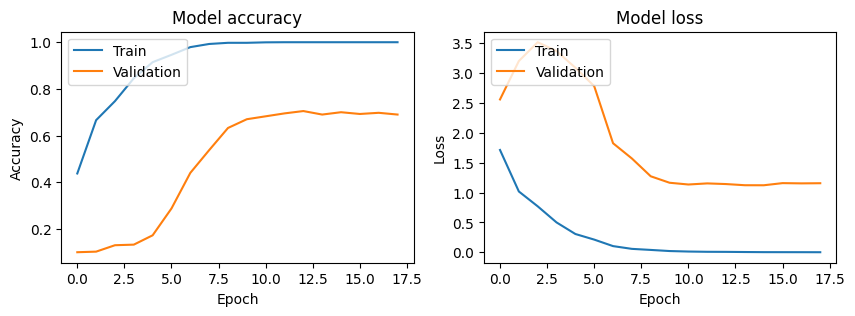

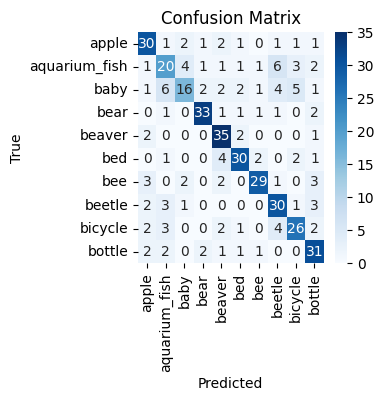

In [12]:
cnn2(dropout=0)

Total training time: 169.77 seconds
Test accuracy: 0.7000
Test loss: 1.1229

0 dropout has clear overfitting as can be expected and it doesn't perform that much better compared to 0.2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.3159 - loss: 2.1802 - val_accuracy: 0.1000 - val_loss: 3.1079
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5421 - loss: 1.3537 - val_accuracy: 0.1025 - val_loss: 3.3763
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.6112 - loss: 1.1757 - val_accuracy: 0.0975 - val_loss: 3.5795
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6672 - loss: 0.9920 - val_accuracy: 0.1425 - val_loss: 3.6505
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.7038 - loss: 0.8625 - val_accuracy: 0.1150 - val_loss: 3.1803
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.7424 - loss: 0.7450 - val_accuracy: 0.2000 - val_loss: 2.7502
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.7972 - loss: 0.5922 - val_accuracy: 0.3350 - val_loss: 2.1738
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8399 - loss: 0.5018 - val_accuracy

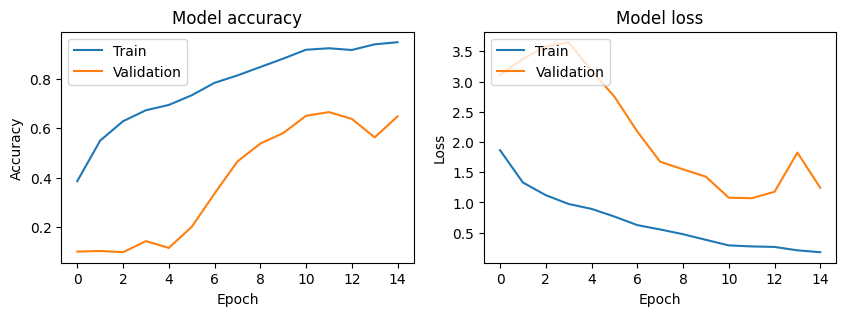

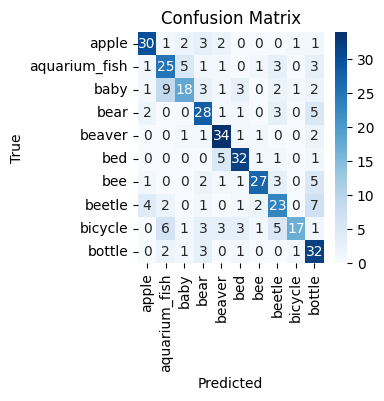

In [31]:
# Trying with swish to see if it still performs as well as before
cnn2(activation='swish')

Total training time: 131.18 seconds
Test accuracy: 0.6650
Test loss: 1.0702

Accuracy drops but loss stays pretty much the same

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.2838 - loss: 2.2518 - val_accuracy: 0.1000 - val_loss: 2.4572
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.5408 - loss: 1.4170 - val_accuracy: 0.1000 - val_loss: 2.9690
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.5999 - loss: 1.2077 - val_accuracy: 0.1000 - val_loss: 3.8392
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.6469 - loss: 1.0404 - val_accuracy: 0.1000 - val_loss: 4.3698
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.7272 - loss: 0.8645 - val_accuracy: 0.1000 - val_loss: 4.7044
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.7394 - loss: 0.7449 - val_accuracy: 0.1275 - val_loss: 4.4615
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.7804 - loss: 0.6514 - val_accuracy: 0.1250 - val_loss: 4.3647
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.8104 - loss: 0.5754 - val_accuracy

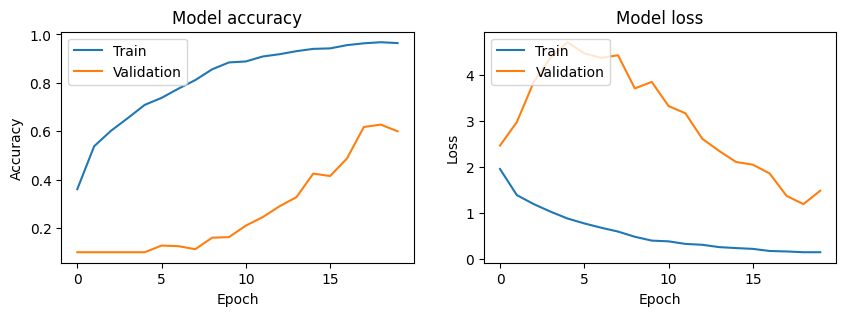

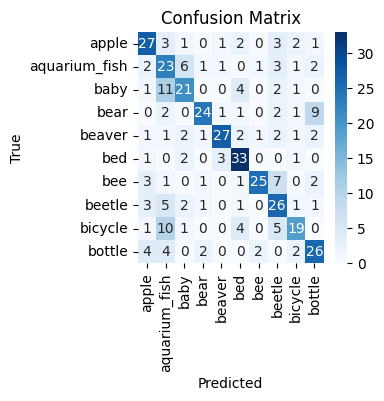

In [13]:
cnn2(activation='swish', batch_size=64)

Total training time: 188.31 seconds
Test accuracy: 0.6275
Test loss: 1.1846

Increasing batch size with this model actually made it worse.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 416ms/step - accuracy: 0.2764 - loss: 2.2194 - val_accuracy: 0.1000 - val_loss: 2.4051
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.4533 - loss: 1.5741 - val_accuracy: 0.1000 - val_loss: 2.6058
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.5377 - loss: 1.3180 - val_accuracy: 0.1325 - val_loss: 3.2236
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.5701 - loss: 1.2307 - val_accuracy: 0.1375 - val_loss: 3.0242
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 380ms/step - accuracy: 0.6147 - loss: 1.0952 - val_accuracy: 0.1675 - val_loss: 3.5297
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 376ms/step - accuracy: 0.6817 - loss: 0.9158 - val_accuracy: 0.2375 - val_loss: 2.6677
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - accuracy: 0.7454 - loss: 0.7809 - val_accuracy: 0.3075 - val_loss: 2.2143
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - accuracy: 0.7828 - loss: 0.6301 - val_accu

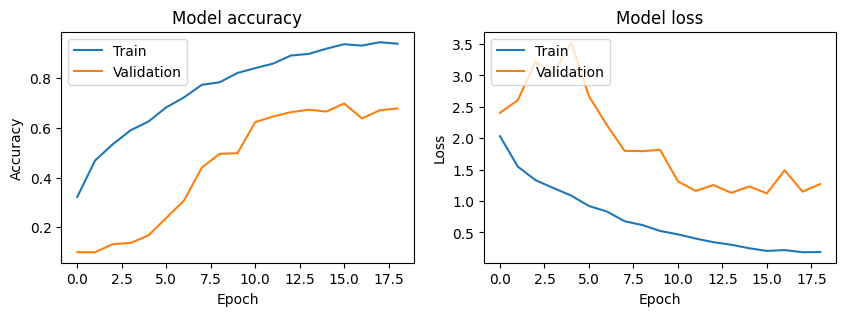

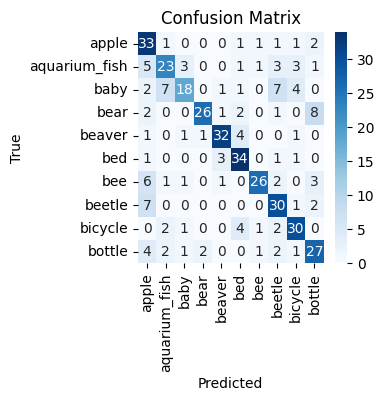

In [17]:
cnn2(activation='swish', conv_layers=5)

Total training time: 721.28 seconds
Test accuracy: 0.6975
Test loss: 1.1226

Swish doesn't work any better with more layers. The best version with swish is the one with three stacks of two convolutional layers

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 418ms/step - accuracy: 0.2361 - loss: 2.3743 - val_accuracy: 0.1450 - val_loss: 2.5125
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 376ms/step - accuracy: 0.4366 - loss: 1.6102 - val_accuracy: 0.0950 - val_loss: 3.1407
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.5115 - loss: 1.4010 - val_accuracy: 0.0975 - val_loss: 3.5521
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.5804 - loss: 1.2352 - val_accuracy: 0.1675 - val_loss: 3.0999
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 384ms/step - accuracy: 0.6220 - loss: 1.1147 - val_accuracy: 0.2125 - val_loss: 3.1557
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - accuracy: 0.6659 - loss: 0.9564 - val_accuracy: 0.3100 - val_loss: 2.3335
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.7167 - loss: 0.8655 - val_accuracy: 0.3825 - val_loss: 2.2009
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - accuracy: 0.6923 - loss: 0.8813 - val_accu

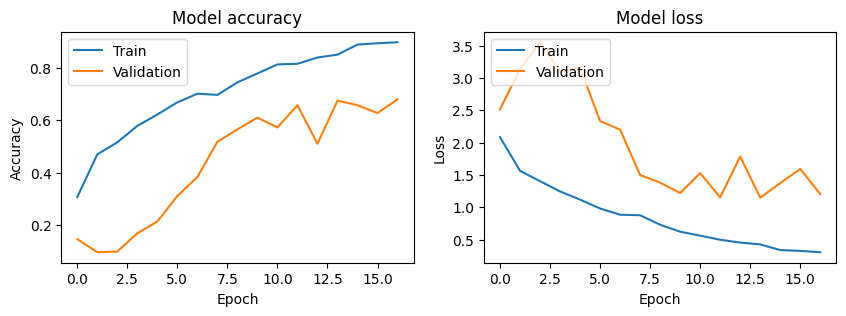

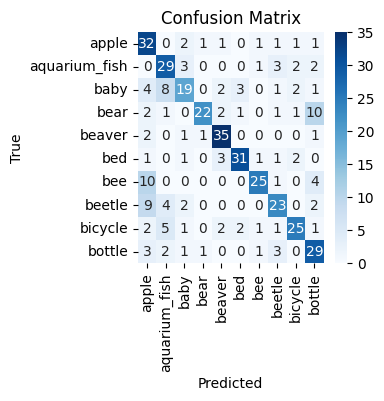

In [16]:
cnn2(conv_layers=5)

Total training time: 640.03 seconds
Test accuracy: 0.6750
Test loss: 1.1489

Swish was better than relu with more layers.

## Third iteration of the model

In [8]:
# Here I added learning rate scheduler when using sgd

def cnn3(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        decay_rate=0.9,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        #model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        #model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=decay_rate
        )
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.1977 - loss: 2.4751 - val_accuracy: 0.1275 - val_loss: 2.3614
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.4077 - loss: 1.7518 - val_accuracy: 0.1275 - val_loss: 2.5069
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.4767 - loss: 1.4958 - val_accuracy: 0.1375 - val_loss: 2.6470
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.5297 - loss: 1.3510 - val_accuracy: 0.1325 - val_loss: 2.9894
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.5359 - loss: 1.3513 - val_accuracy: 0.1750 - val_loss: 2.6522
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5642 - loss: 1.2821 - val_accuracy: 0.2650 - val_loss: 2.0507
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.6202 - loss: 1.1740 - val_accuracy: 0.3300 - val_loss: 1.9486
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.6283 - loss: 1.0988 - val_accuracy

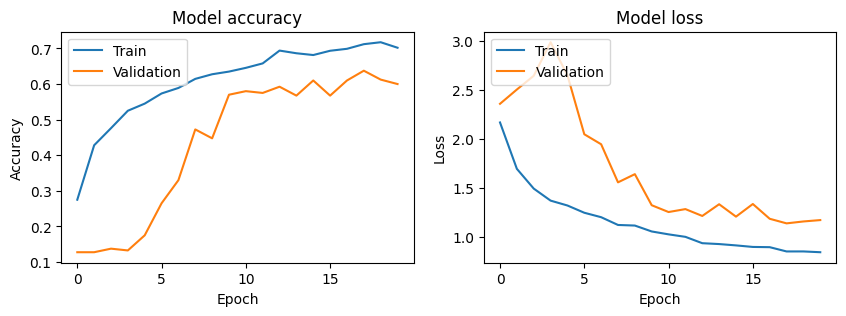

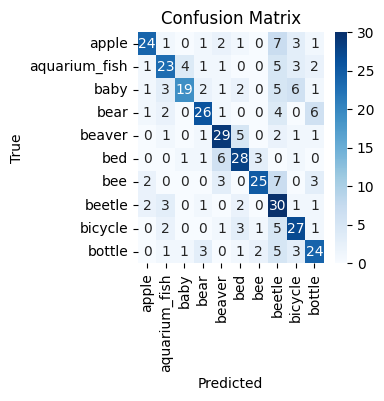

In [ ]:
cnn3(optimizer_name='sgd', learning_rate=0.01)

Total training time: 194.39 seconds
Test accuracy: 0.6375
Test loss: 1.1418

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.1365 - loss: 2.7560 - val_accuracy: 0.1025 - val_loss: 2.3854
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.2088 - loss: 2.4131 - val_accuracy: 0.1150 - val_loss: 2.4199
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.2742 - loss: 2.1913 - val_accuracy: 0.1250 - val_loss: 2.4208
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.3022 - loss: 2.0579 - val_accuracy: 0.1225 - val_loss: 2.3775
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3451 - loss: 1.9181 - val_accuracy: 0.2125 - val_loss: 2.2979
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.3346 - loss: 1.9067 - val_accuracy: 0.2675 - val_loss: 2.1150
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.3890 - loss: 1.7957 - val_accuracy: 0.3150 - val_loss: 2.0050
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.3948 - loss: 1.7805 - val_accuracy: 0.34

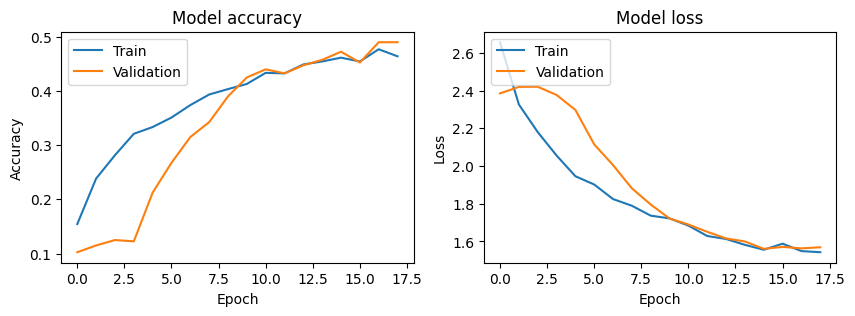

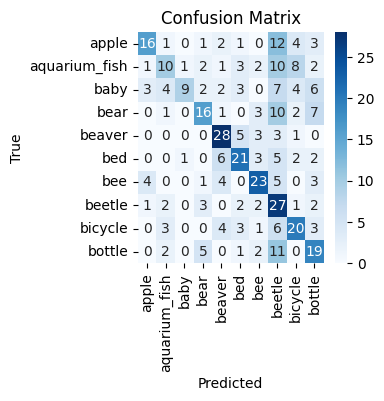

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.0930 - loss: 2.8423 - val_accuracy: 0.1050 - val_loss: 2.3947
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.1915 - loss: 2.4862 - val_accuracy: 0.1475 - val_loss: 2.4667
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2283 - loss: 2.2874 - val_accuracy: 0.1550 - val_loss: 2.4664
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2914 - loss: 2.1141 - val_accuracy: 0.1775 - val_loss: 2.4203
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.3232 - loss: 2.0182 - val_accuracy: 0.2075 - val_loss: 2.3026
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.3355 - loss: 1.9461 - val_accuracy: 0.2125 - val_loss: 2.2316
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.3727 - loss: 1.8546 - val_accuracy: 0.2725 - val_loss: 2.0718
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.3789 - loss: 1.8424 - val_accuracy: 0.33

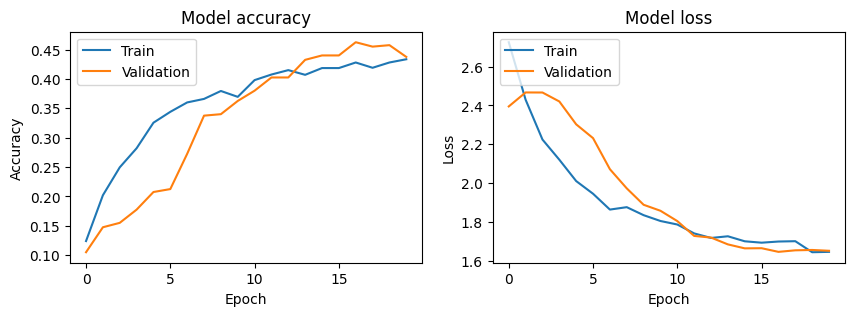

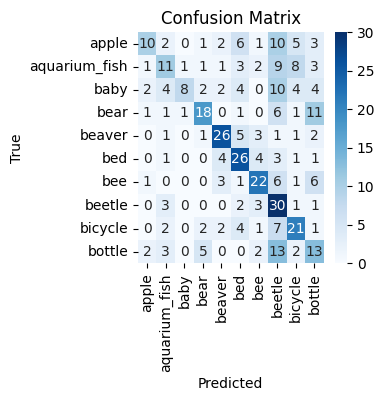

In [15]:
cnn3(optimizer_name='sgd', decay_rate=0.95)
cnn3(optimizer_name='sgd', decay_rate=0.85)

Total training time: 148.51 seconds
Test accuracy: 0.4725
Test loss: 1.5607

Total training time: 174.12 seconds
Test accuracy: 0.4625
Test loss: 1.6464

SGD just doesn't seem to be the number one choice for this model.

## Fourth iteration of the model

In [9]:
# I'll try with added convolutional layers also

def cnn4(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        decay_rate=0.9,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=decay_rate
        )
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.1219 - loss: 2.8442 - val_accuracy: 0.1000 - val_loss: 2.4073
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.2341 - loss: 2.3690 - val_accuracy: 0.1050 - val_loss: 2.4304
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.3029 - loss: 2.1362 - val_accuracy: 0.1175 - val_loss: 2.5016
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - accuracy: 0.2898 - loss: 2.1145 - val_accuracy: 0.1275 - val_loss: 2.5622
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - accuracy: 0.3449 - loss: 1.9233 - val_accuracy: 0.1650 - val_loss: 2.3763
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.3777 - loss: 1.8503 - val_accuracy: 0.2600 - val_loss: 2.2474
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.4154 - loss: 1.7184 - val_accuracy: 0.3150 - val_loss: 2.0531
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.4246 - loss: 1.6694 - val_accu

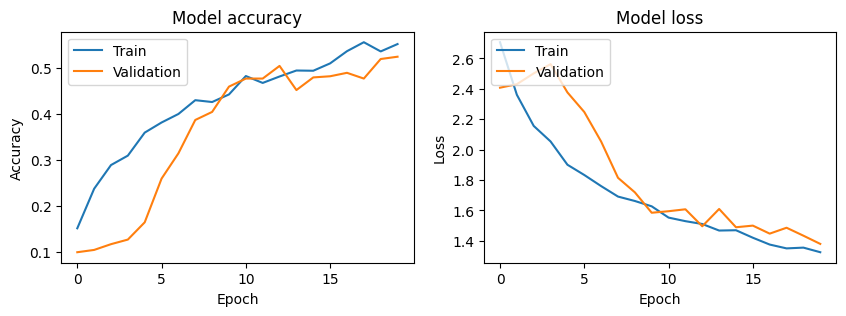

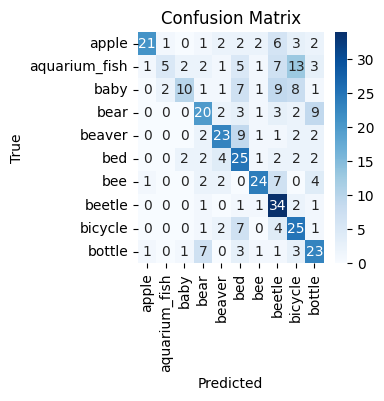

In [10]:
cnn4(optimizer_name='sgd', decay_rate=0.95)

Total training time: 403.90 seconds
Test accuracy: 0.5250
Test loss: 1.3801

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.1313 - loss: 2.8259 - val_accuracy: 0.1000 - val_loss: 2.4526
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.2246 - loss: 2.3338 - val_accuracy: 0.1000 - val_loss: 2.5688
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step - accuracy: 0.3030 - loss: 2.1228 - val_accuracy: 0.1250 - val_loss: 2.6547
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - accuracy: 0.3386 - loss: 2.0050 - val_accuracy: 0.1875 - val_loss: 2.6537
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.3508 - loss: 1.9400 - val_accuracy: 0.1975 - val_loss: 2.5853
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.3610 - loss: 1.9124 - val_accuracy: 0.2425 - val_loss: 2.4239
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.3857 - loss: 1.7844 - val_accuracy: 0.2625 - val_loss: 2.2766
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 0.4075 - loss: 1.8196 - val_accu

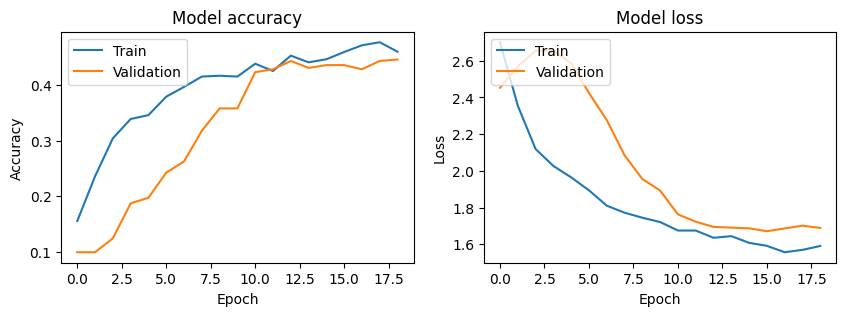

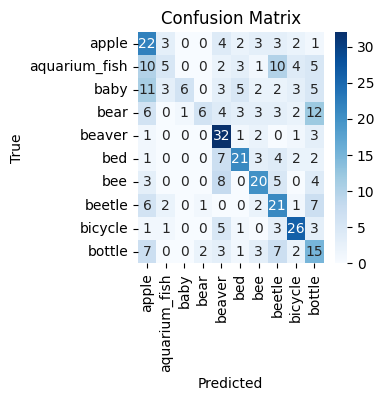

In [11]:
cnn4(optimizer_name='sgd', decay_rate=0.85)

Total training time: 380.90 seconds
Test accuracy: 0.4350
Test loss: 1.6709

SGD doesn't work.

## Fifth iteration of the model

In [22]:
# Global average pooling instead of flatten

def cnn5(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        decay_rate=0.9,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Global average pooling and Dense layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=decay_rate
        )
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - accuracy: 0.2758 - loss: 2.1825 - val_accuracy: 0.1000 - val_loss: 2.4428
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.4835 - loss: 1.5163 - val_accuracy: 0.1000 - val_loss: 3.8164
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.5584 - loss: 1.3196 - val_accuracy: 0.1000 - val_loss: 4.3680
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.5853 - loss: 1.1849 - val_accuracy: 0.1000 - val_loss: 5.3445
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.6316 - loss: 1.0568 - val_accuracy: 0.1100 - val_loss: 4.7639
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.6738 - loss: 0.9756 - val_accuracy: 0.1850 - val_loss: 3.5312
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step - accuracy: 0.7059 - loss: 0.8341 - val_accuracy: 0.3075 - val_loss: 2.5385
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.7510 - loss: 0.7560 - val_accu

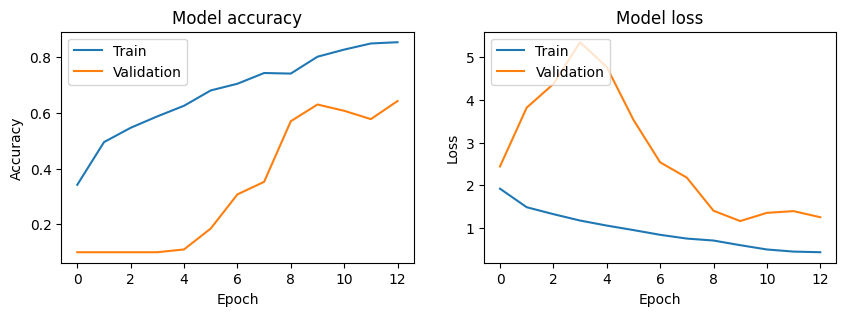

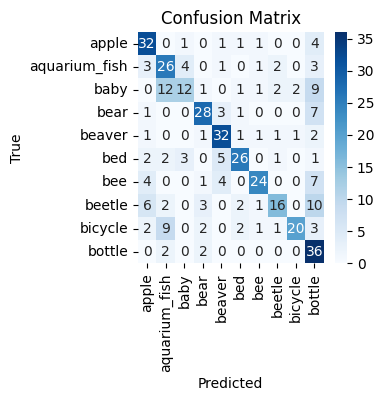

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 363ms/step - accuracy: 0.3085 - loss: 2.1720 - val_accuracy: 0.1000 - val_loss: 2.3773
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.4439 - loss: 1.5912 - val_accuracy: 0.1000 - val_loss: 3.4123
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 299ms/step - accuracy: 0.5410 - loss: 1.3721 - val_accuracy: 0.1000 - val_loss: 3.9843
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.6077 - loss: 1.1333 - val_accuracy: 0.1425 - val_loss: 3.2247
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.6610 - loss: 0.9944 - val_accuracy: 0.1525 - val_loss: 3.5047
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.6928 - loss: 0.9150 - val_accuracy: 0.2525 - val_loss: 2.4381
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.7530 - loss: 0.7722 - val_accuracy: 0.3650 - val_loss: 1.8712
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.7918 - loss: 0.6323 - val_accu

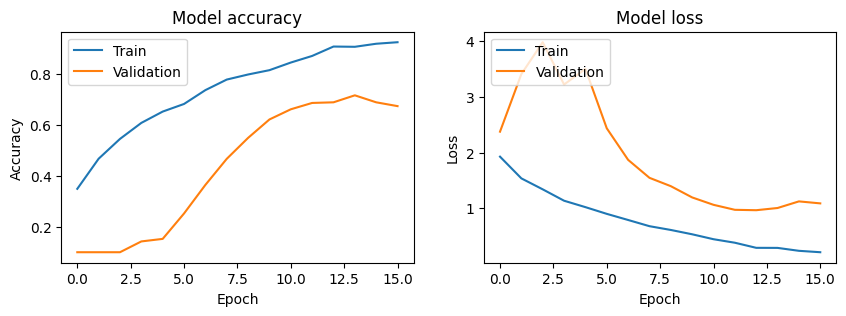

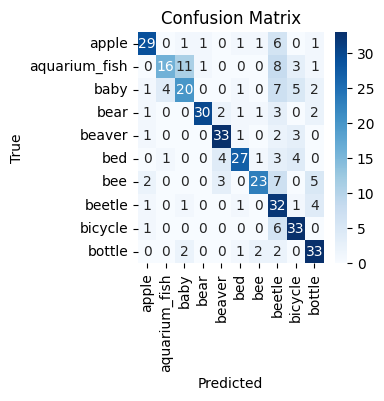

In [19]:
cnn5()
cnn5(activation='swish')

Total training time: 271.04 seconds
Test accuracy: 0.6300
Test loss: 1.1656

Base version of this model isn't any better

Total training time: 345.35 seconds
Test accuracy: 0.6900
Test loss: 0.9665

With swish it performs pretty close to the best one yet.

##Sixth iteration of the model

In [22]:
# Adding another dense layer

def cnn6(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        decay_rate=0.9,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Global average pooling and Dense layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(dense_units // 2, activation=activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=decay_rate
        )
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.1914 - loss: 2.3435 - val_accuracy: 0.1200 - val_loss: 2.4458
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.3662 - loss: 1.7945 - val_accuracy: 0.1275 - val_loss: 3.2152
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - accuracy: 0.4506 - loss: 1.5582 - val_accuracy: 0.1000 - val_loss: 3.5740
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.4964 - loss: 1.4234 - val_accuracy: 0.1300 - val_loss: 3.1822
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.5550 - loss: 1.3645 - val_accuracy: 0.1400 - val_loss: 3.7530
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.5745 - loss: 1.2120 - val_accuracy: 0.2275 - val_loss: 3.6580
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 0.6152 - loss: 1.1607 - val_accuracy: 0.2725 - val_loss: 2.2666
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.6186 - loss: 1.0810 - val_accu

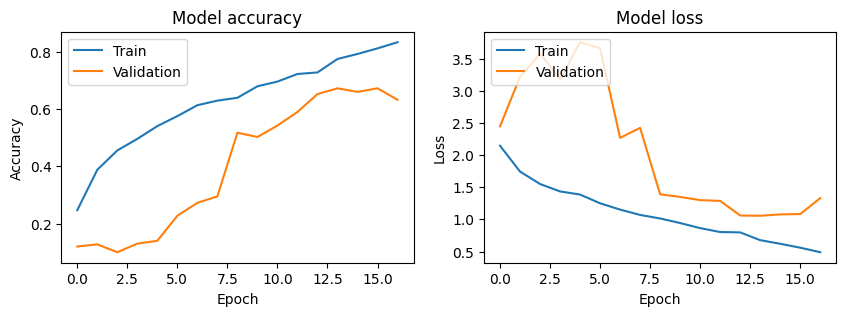

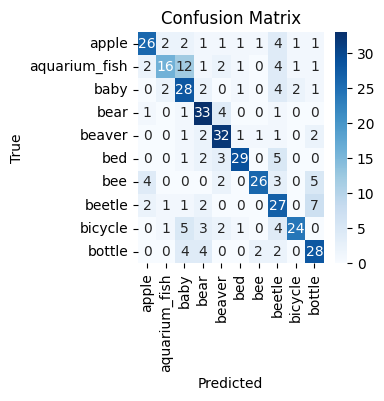

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 366ms/step - accuracy: 0.2542 - loss: 2.1600 - val_accuracy: 0.1000 - val_loss: 2.3375
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.4186 - loss: 1.6579 - val_accuracy: 0.1000 - val_loss: 2.7025
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 298ms/step - accuracy: 0.4897 - loss: 1.4589 - val_accuracy: 0.1000 - val_loss: 3.3413
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.5451 - loss: 1.2984 - val_accuracy: 0.1450 - val_loss: 3.4314
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.6130 - loss: 1.1476 - val_accuracy: 0.1600 - val_loss: 2.6418
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - accuracy: 0.6244 - loss: 1.1006 - val_accuracy: 0.2200 - val_loss: 2.6547
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 315ms/step - accuracy: 0.6724 - loss: 0.9782 - val_accuracy: 0.2550 - val_loss: 2.0417
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - accuracy: 0.6916 - loss: 0.9110 - val_accu

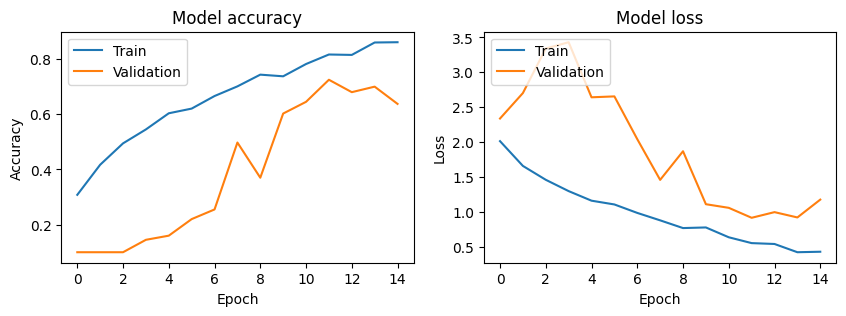

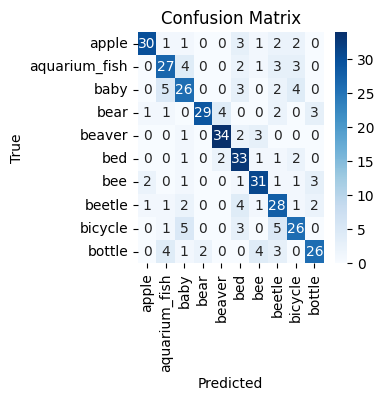

In [24]:
cnn6()
cnn6(activation='swish')

Total training time: 335.84 seconds
Test accuracy: 0.6725
Test loss: 1.0560

This one is pretty close to the original baseline, but doesnt seem to be overfitting that badly.

Total training time: 373.63 seconds
Test accuracy: 0.7250
Test loss: 0.9143

These are the best scores so far. And the model isn't overfitting so bad after applying the second dense layer.

(I just now noticed that the class names in the confusion matrices are wrong. I corrected my code in the beginning of the notebook so they should be correct from this point on)

## Seventh iteration of the model

In [33]:
# Switching the loop a bit, now BatchNormalization is before activation layer.

def cnn7(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        decay_rate=0.9,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

        model.add(layers.Conv2D(filters, (3, 3), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Global average pooling and Dense layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(dense_units // 2, activation=activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=decay_rate
        )
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.2220 - loss: 2.2686 - val_accuracy: 0.1000 - val_loss: 2.4504
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - accuracy: 0.3576 - loss: 1.8305 - val_accuracy: 0.1400 - val_loss: 2.8305
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.4284 - loss: 1.6432 - val_accuracy: 0.1250 - val_loss: 3.3136
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.5420 - loss: 1.3960 - val_accuracy: 0.1125 - val_loss: 3.2916
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.5476 - loss: 1.3278 - val_accuracy: 0.2150 - val_loss: 2.3775
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.5810 - loss: 1.2174 - val_accuracy: 0.3450 - val_loss: 2.1560
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - accuracy: 0.6085 - loss: 1.0987 - val_accuracy: 0.3750 - val_loss: 1.7548
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.6410 - loss: 1.0625 - val_accu

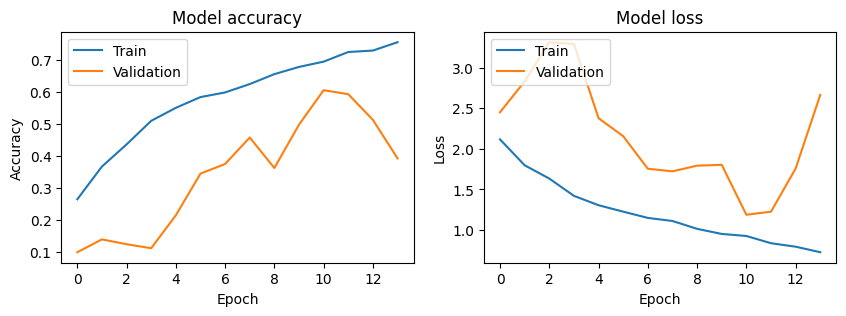

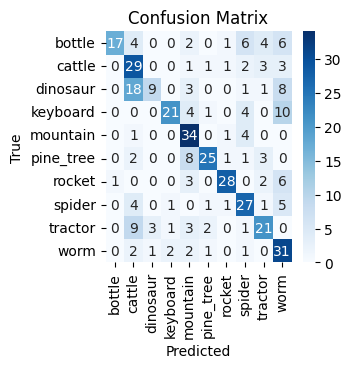

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 0.2119 - loss: 2.2607 - val_accuracy: 0.1000 - val_loss: 2.3008
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.4219 - loss: 1.6850 - val_accuracy: 0.1250 - val_loss: 2.3186
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.4696 - loss: 1.5294 - val_accuracy: 0.1450 - val_loss: 2.5203
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.5398 - loss: 1.3368 - val_accuracy: 0.1550 - val_loss: 2.4156
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.5821 - loss: 1.2607 - val_accuracy: 0.2875 - val_loss: 1.9394
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - accuracy: 0.6143 - loss: 1.1450 - val_accuracy: 0.4350 - val_loss: 1.6471
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.5945 - loss: 1.1242 - val_accuracy: 0.5300 - val_loss: 1.3975
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.6631 - loss: 0.9922 - val_accu

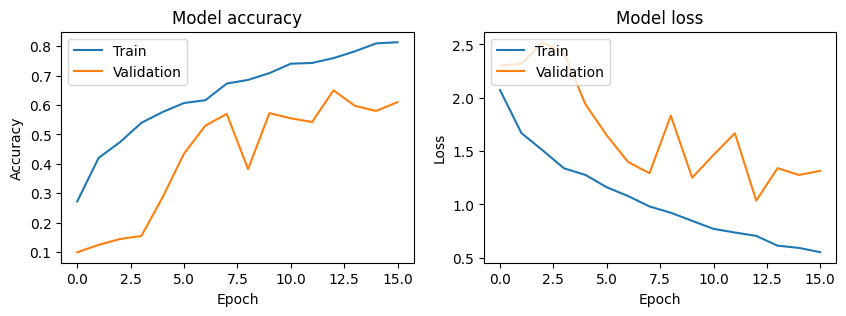

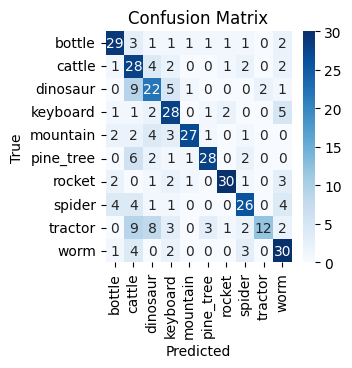

In [31]:
cnn7()
cnn7(activation='swish')

Total training time: 279.96 seconds
Test accuracy: 0.6050
Test loss: 1.1881

Total training time: 348.76 seconds
Test accuracy: 0.6500
Test loss: 1.0356

This didn't help at all.

## Eight iteration of the model

In [38]:
# Switching back to flatten and previous loop config.

def cnn8(train_data=x_train_selected,
        train_labels=y_train_selected,
        val_data=x_test_selected,
        val_labels=y_test_selected,
        activation='relu',
        dropout=0.2,
        optimizer_name='adam',
        learning_rate=0.001,
        decay_rate=0.9,
        epochs=20,
        conv_layers=3,
        filters = 32,
        dense_units=128,
        batch_size=32,
        ):

    # Initialize model
    model = Sequential()

    # Loop for Convolutional layers
    for i in range(conv_layers):
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation,
                                input_shape=(32, 32, 3) if i == 0 else None))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, (3, 3), padding='same', activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout))
        filters *= 2

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(dense_units // 2, activation=activation))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Optimizer
    optimizer = optimizers.get(optimizer_name)
    if optimizer_name == 'adam' or optimizer_name == 'rmsprop':
        optimizer.learning_rate.assign(learning_rate)
    elif optimizer_name == 'sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=decay_rate
        )
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5)

    # Training
    start_time = time.time()  # Start timer
    history = model.fit(train_data,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=1,
                        callbacks=[early_stopping])


    end_time = time.time()  # End timer

    # Model evaluation
    test_loss, test_acc = model.evaluate(val_data, val_labels)

    y_pred = model.predict(val_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(val_labels, axis=1)

    # Print testing accuracy and loss
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Plot training and validation accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names,
                yticklabels=selected_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - accuracy: 0.2544 - loss: 2.1885 - val_accuracy: 0.1950 - val_loss: 2.5277
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 291ms/step - accuracy: 0.4860 - loss: 1.5043 - val_accuracy: 0.1200 - val_loss: 2.9288
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - accuracy: 0.5574 - loss: 1.3372 - val_accuracy: 0.1050 - val_loss: 3.5408
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.6032 - loss: 1.1385 - val_accuracy: 0.1400 - val_loss: 3.3280
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.6551 - loss: 1.0070 - val_accuracy: 0.2000 - val_loss: 2.7225
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.7251 - loss: 0.8079 - val_accuracy: 0.3100 - val_loss: 2.2785
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.7790 - loss: 0.6691 - val_accuracy: 0.4000 - val_loss: 1.9529
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - accuracy: 0.8100 - loss: 0.5771 - val_accu

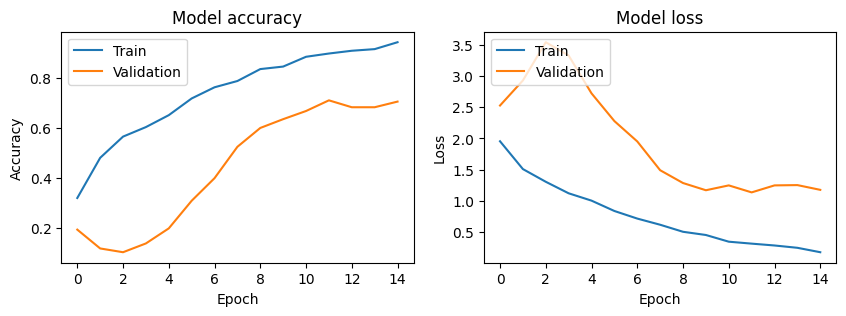

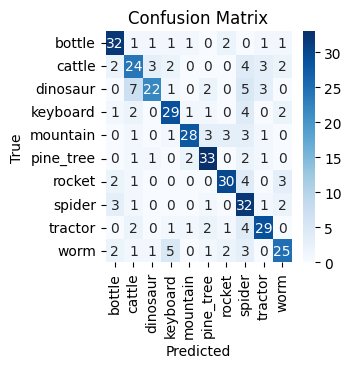

In [39]:
cnn8(activation='swish')

Total training time: 331.05 seconds
Test accuracy: 0.7100
Test loss: 1.1375

This was closer to iter6 but not as good. I will stick with iter6 and experiment a little bit more with it.

# Tuning the best model configuration

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 673ms/step - accuracy: 0.2435 - loss: 2.1444 - val_accuracy: 0.1000 - val_loss: 2.3070
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 674ms/step - accuracy: 0.4009 - loss: 1.7354 - val_accuracy: 0.1325 - val_loss: 2.3485
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 648ms/step - accuracy: 0.5137 - loss: 1.3964 - val_accuracy: 0.1000 - val_loss: 2.4696
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.5508 - loss: 1.2573 - val_accuracy: 0.1000 - val_loss: 2.6447
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 653ms/step - accuracy: 0.6104 - loss: 1.1221 - val_accuracy: 0.1000 - val_loss: 2.8421
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step - accuracy: 0.6516 - loss: 0.9823 - val_accuracy: 0.1000 - val_loss: 3.4193
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 687ms/step - accuracy: 0.6930 - loss: 0.8984 - val_accuracy: 0.1050 - val_loss: 3.5707
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 636ms/step - accuracy: 0.7431 - loss: 0.7583 - val_accu

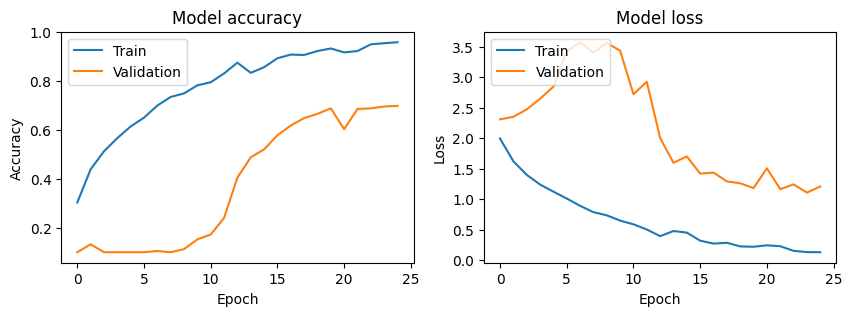

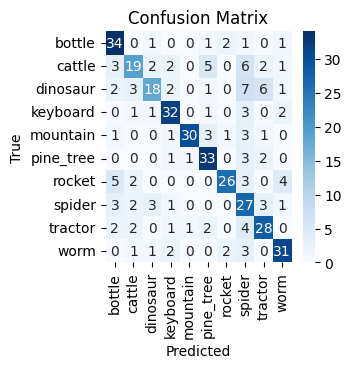

In [11]:
cnn6(activation='swish', dense_units=256, batch_size=64, epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.2200 - loss: 2.2530 - val_accuracy: 0.1500 - val_loss: 2.3606
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.3459 - loss: 1.8722 - val_accuracy: 0.1375 - val_loss: 2.8500
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.4304 - loss: 1.6649 - val_accuracy: 0.2325 - val_loss: 2.4452
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.4320 - loss: 1.6255 - val_accuracy: 0.3025 - val_loss: 2.0861
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.4940 - loss: 1.4422 - val_accuracy: 0.5600 - val_loss: 1.3960
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.5607 - loss: 1.2840 - val_accuracy: 0.3325 - val_loss: 2.1297
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.6011 - loss: 1.1850 - val_accuracy: 0.4925 - val_loss: 1.5826
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.6171 - loss: 1

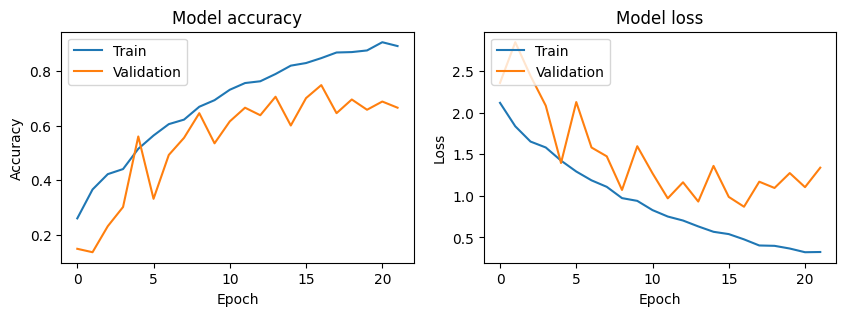

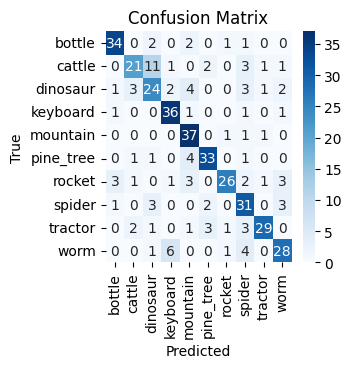

In [30]:
cnn6(activation='swish', dense_units=64, batch_size=16, epochs=25)

Total training time: 682.28 seconds
Test accuracy: 0.7475
Test loss: 0.8698

Best one so far

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.2264 - loss: 2.3113 - val_accuracy: 0.1000 - val_loss: 2.3639
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.3785 - loss: 1.7762 - val_accuracy: 0.0925 - val_loss: 2.4309
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.4685 - loss: 1.6185 - val_accuracy: 0.1050 - val_loss: 2.7403
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 325ms/step - accuracy: 0.5191 - loss: 1.3893 - val_accuracy: 0.0975 - val_loss: 3.5004
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.5688 - loss: 1.3008 - val_accuracy: 0.1650 - val_loss: 3.5130
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.6373 - loss: 1.1620 - val_accuracy: 0.2475 - val_loss: 2.5021
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.6399 - loss: 1.0629 - val_accuracy: 0.4350 - val_loss: 1.7792
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 321ms/step - accuracy: 0.6905 - loss: 0.9507 - val_accu

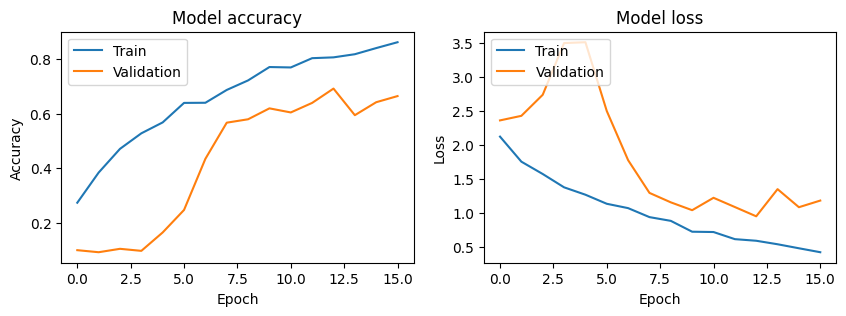

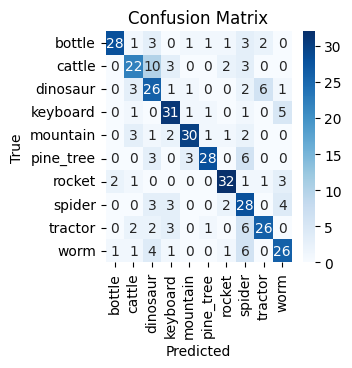

In [15]:
cnn6(activation='swish', dense_units=64, epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 180ms/step - accuracy: 0.2515 - loss: 2.2011 - val_accuracy: 0.1100 - val_loss: 2.3983
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.3928 - loss: 1.7417 - val_accuracy: 0.1250 - val_loss: 2.9413
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.4638 - loss: 1.5619 - val_accuracy: 0.1425 - val_loss: 3.0299
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.5161 - loss: 1.4211 - val_accuracy: 0.4200 - val_loss: 1.8257
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.5915 - loss: 1.2267 - val_accuracy: 0.5350 - val_loss: 1.3445
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.6195 - loss: 1.1166 - val_accuracy: 0.5450 - val_loss: 1.3785
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.6740 - loss: 0.9491 - val_accuracy: 0.5800 - val_loss: 1.3092
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.7258 - loss: 0

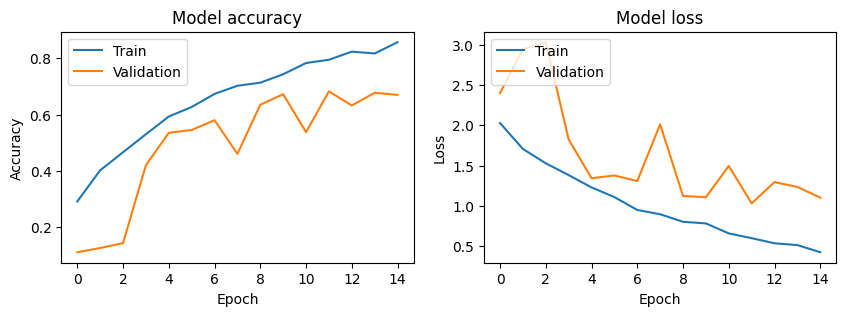

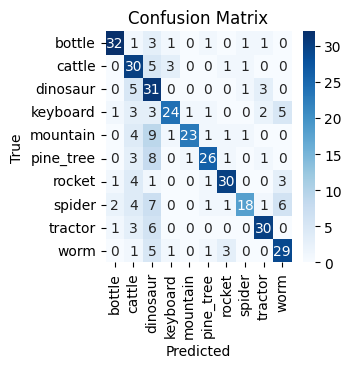

In [16]:
cnn6(activation='swish', batch_size=16, epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.1893 - loss: 2.3119 - val_accuracy: 0.1125 - val_loss: 2.3866
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.3214 - loss: 1.8977 - val_accuracy: 0.1350 - val_loss: 3.3780
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.3985 - loss: 1.7191 - val_accuracy: 0.1500 - val_loss: 2.8955
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.4839 - loss: 1.5852 - val_accuracy: 0.3950 - val_loss: 1.8978
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.5052 - loss: 1.4492 - val_accuracy: 0.5100 - val_loss: 1.4739
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.5524 - loss: 1.3163 - val_accuracy: 0.5575 - val_loss: 1.3125
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.5898 - loss: 1.1793 - val_accuracy: 0.6125 - val_loss: 1.2436
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.6700 - loss: 0

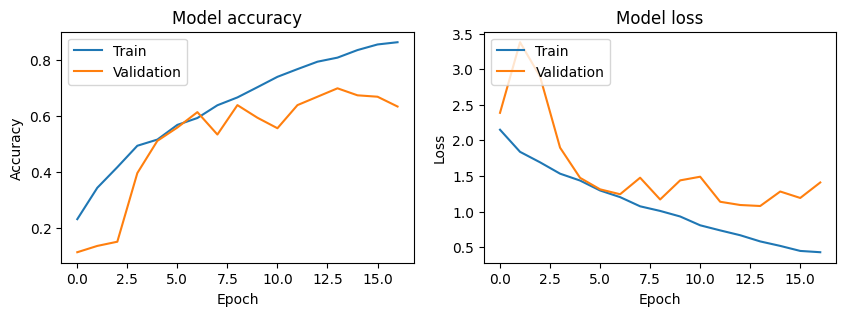

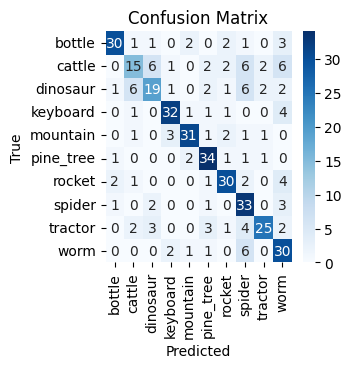

In [9]:
cnn6(activation='swish', dense_units=64, batch_size=16, conv_layers=4, epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.2184 - loss: 2.2057 - val_accuracy: 0.1350 - val_loss: 2.3591
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.3647 - loss: 1.7927 - val_accuracy: 0.1350 - val_loss: 2.6162
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.4303 - loss: 1.6562 - val_accuracy: 0.1500 - val_loss: 2.6584
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.4470 - loss: 1.5385 - val_accuracy: 0.4375 - val_loss: 1.6487
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.5144 - loss: 1.3914 - val_accuracy: 0.4425 - val_loss: 1.5451
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.5588 - loss: 1.3236 - val_accuracy: 0.5975 - val_loss: 1.2070
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.5766 - loss: 1.2219 - val_accuracy: 0.2000 - val_loss: 3.1358
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.6023 - loss: 1

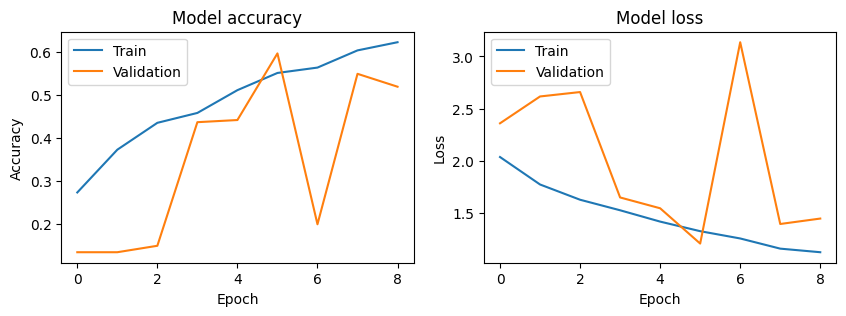

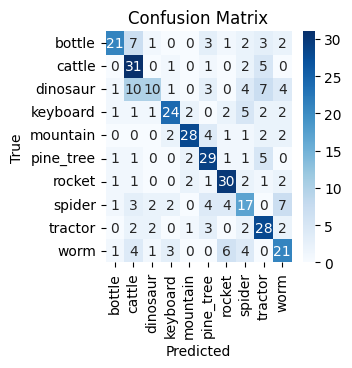

In [11]:
cnn6(activation='swish', dense_units=64, batch_size=16, conv_layers=2, epochs=25)

I'll use the cnn6 as my final model with dense_units=64 and batch_size=16. I'll test it again with the remainder of the CIFAR-100 image set to see how it performs.

## Final model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.2096 - loss: 2.2722 - val_accuracy: 0.1000 - val_loss: 2.5295
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.3537 - loss: 1.8171 - val_accuracy: 0.1000 - val_loss: 3.1750
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.4541 - loss: 1.5834 - val_accuracy: 0.1450 - val_loss: 5.6900
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.4975 - loss: 1.4571 - val_accuracy: 0.4450 - val_loss: 1.5569
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.5711 - loss: 1.2396 - val_accuracy: 0.4925 - val_loss: 1.7202
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.5969 - loss: 1.1613 - val_accuracy: 0.5075 - val_loss: 1.5409
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.6241 - loss: 1.1291 - val_accuracy: 0.5375 - val_loss: 1.3723
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.6638 - loss: 0

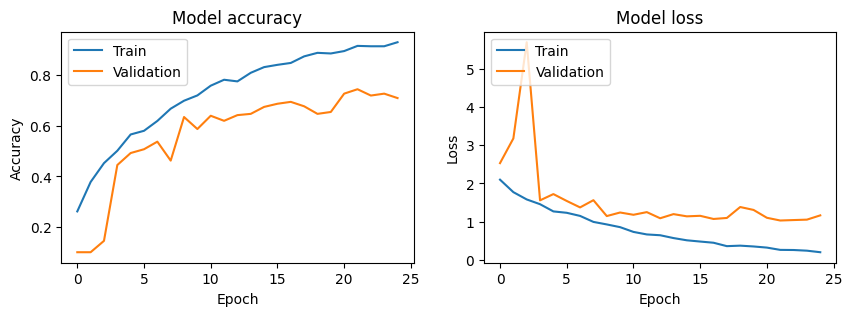

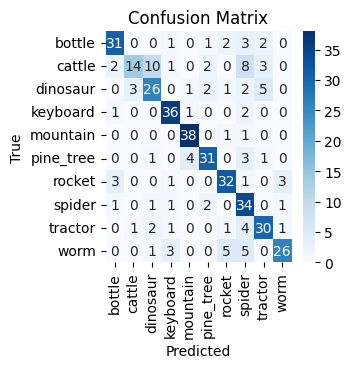

In [28]:
final_model = cnn6(activation='swish', dense_units=64, batch_size=16, epochs=25)

Next will be saving the model and printing out the summary to get a better view of what the model is made out of and also to see the number of parameters in the model.

In [38]:
final_model.model.save('final_model.keras')

In [40]:
model = tf.keras.models.load_model('final_model.keras')
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_104 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_121              │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_122              │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_123              │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_124              │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_125              │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_126              │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 598,422 (2.28 MB)

 Trainable params: 298,698 (1.14 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 298,700 (1.14 MB)

Here is the summary of the final model.
It consists of: <br>
6 Convolutional Layers <br>
3 Max Pooling Layers <br>
7 times Batch Normalization <br>
4 times Dropout <br>
1 Global Average Pooling <br>
3 Dense Layers <br><br>

Total params: 598,422 <br>
Trainable params: 298,698 <br>
Non-trainable params: 1,024 <br>
Optimizer params: 298,700 <br>

## Testing with new images from same classes

In [13]:
# Here I'm taking all the unused images from the training set for the selected classes and testing the model with them

x_final_test, y_final_test = [], []

for class_id in classes:
    # Indices of all images in the training set
    all_train_indices = np.where(y_train.flatten() == class_id)[0]

    # Indices of images NOT initially used for training
    final_test_indices = all_train_indices[num_images:]

    # Add the not used images to the new test set
    x_final_test.extend(x_train[final_test_indices])
    y_final_test.extend(y_train[final_test_indices])

# Convert lists to NumPy arrays
x_final_test = np.array(x_final_test)
y_final_test = np.array(y_final_test)

# Create a mapping from original class labels to new labels (0 to 9)
class_mapping = {class_id: i for i, class_id in enumerate(classes)}

# Map original class labels to new labels
y_final_test = np.vectorize(class_mapping.get)(y_final_test)

# One-hot encode the labels
y_final_test = tf.keras.utils.to_categorical(y_final_test, len(classes))

# Normalize the image data
x_final_test = x_final_test.astype("float32") / 255

In [42]:
test_loss, test_acc = model.evaluate(x_final_test, y_final_test)
print(f"Test accuracy on unseen data: {test_acc:.4f}")
print(f"Test loss on unseen data: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7064 - loss: 1.0902
Test accuracy on unseen data: 0.7260
Test loss on unseen data: 0.9612


Final accuracy of the model when testing with images that weren't used in the training or validation is 0.7260. I'll now try the model with new image classes as well to see how it generalizes with different images, because now it's optimized with the initially chosen classes.

## Testing with new image classes

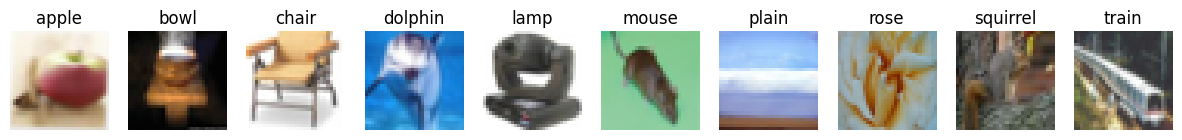

In [44]:
# This is basically just a copy of the code from the beginning of the project.
# This could've been done using a function but I don't mind having to use the same code again this way.

# Using 10 classes and 200 images per class
classes_new = [0,10,20,30,40,50,60,70,80,90]

# Names of the selected classes
selected_class_names_new = [class_names[i] for i in classes_new]

# Create the test and training sets
x_train_new, y_train_new = [], []
x_test_new, y_test_new = [], []

for class_id in classes_new:
    train_indices_new = np.where(y_train.flatten() == class_id)[0][:num_images]
    test_indices_new = np.where(y_test.flatten() == class_id)[0][:num_images // 5]

    x_train_new.append(x_train[train_indices_new])
    y_train_new.append(y_train[train_indices_new])
    x_test_new.append(x_test[test_indices_new])
    y_test_new.append(y_test[test_indices_new])

# Convert lists to NumPy arrays
x_train_new = np.concatenate(x_train_new, axis=0)
y_train_new = np.concatenate(y_train_new, axis=0)
x_test_new = np.concatenate(x_test_new, axis=0)
y_test_new = np.concatenate(y_test_new, axis=0)

# Create a mapping from original class labels to new labels (0 to 9)
class_mapping_new = {class_id: i for i, class_id in enumerate(classes_new)}

# Map original class labels to new labels
y_train_new = np.vectorize(class_mapping_new.get)(y_train_new)
y_test_new = np.vectorize(class_mapping_new.get)(y_test_new)

# One-hot encode the labels
y_train_new = tf.keras.utils.to_categorical(y_train_new, len(classes_new))
y_test_new = tf.keras.utils.to_categorical(y_test_new, len(classes_new))

# Normalize the image data
x_train_new = x_train_new.astype("float32") / 255
x_test_new = x_test_new.astype("float32") / 255

# Display one image from each class
fig, axes = plt.subplots(1, len(classes_new), figsize=(15, 3))

for i, class_id in enumerate(classes_new):
    index = np.where(y_train.flatten() == class_id)[0][0]  # Select first occurrence
    image = x_train[index]

    axes[i].imshow(image)
    axes[i].set_title(class_names[class_id])
    axes[i].axis("off")

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 179ms/step - accuracy: 0.3064 - loss: 2.0232 - val_accuracy: 0.1000 - val_loss: 2.8918
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.4611 - loss: 1.5864 - val_accuracy: 0.1075 - val_loss: 2.9134
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.4942 - loss: 1.4753 - val_accuracy: 0.2625 - val_loss: 2.2013
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.5417 - loss: 1.3259 - val_accuracy: 0.3150 - val_loss: 1.8892
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.5648 - loss: 1.2649 - val_accuracy: 0.6025 - val_loss: 1.1716
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.5964 - loss: 1.1851 - val_accuracy: 0.5425 - val_loss: 1.2367
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.6422 - loss: 1.0520 - val_accuracy: 0.6325 - val_loss: 1.0958
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.6719 - loss: 0

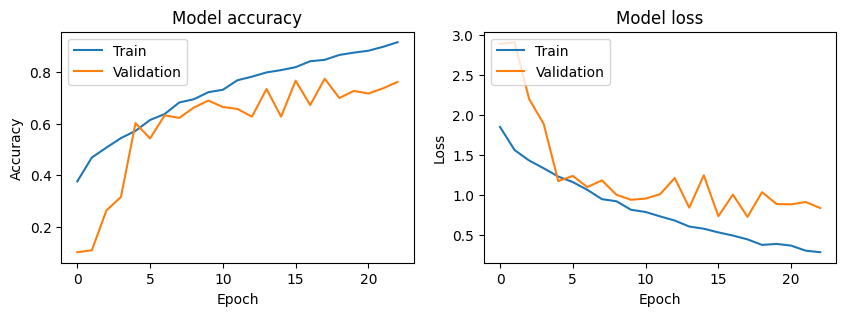

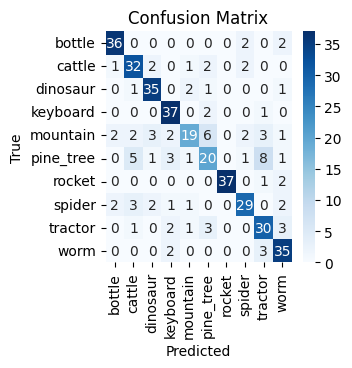

In [45]:
cnn6(train_data=x_train_new,
        train_labels=y_train_new,
        val_data=x_test_new,
        val_labels=y_test_new,
        activation='swish',
        dense_units=64,
        batch_size=16,
        epochs=25)

The model works very well with other image classes aswell obtaining even higher validation accuracy than before with the original classes. Also there is little to none overfitting especially compared with many of the previous iterations of the model with many different hyperparameter combinations.

## Visualizing the model

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


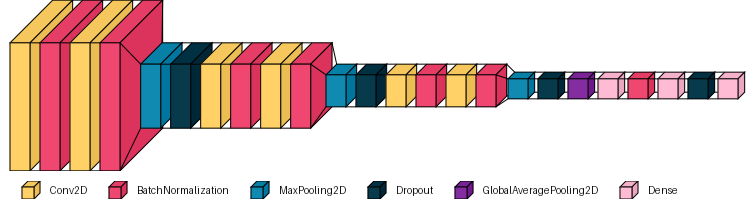

In [59]:
# Visualization of the model as a picture that shows different layers

import visualkeras
from PIL import Image

# Create and save the visualization
visualkeras.layered_view(model, legend=True, to_file='model_visualization.png').save('model_visualization.png')

# Display the image
display(Image.open('model_visualization.png'))